In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
# Adding the top layer
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [10]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='malimg-resnet50-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [11]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Initial acurracy: 0.0349
Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 97s - loss: 0.2482 - acc: 0.9373 - val_loss: 6.3543 - val_acc: 0.2762
Epoch 2/100
8394/8394 [==============================] - 88s - loss: 0.0782 - acc: 0.9744 - val_loss: 1.0149 - val_acc: 0.7905
Epoch 3/100
8394/8394 [==============================] - 88s - loss: 0.0713 - acc: 0.9776 - val_loss: 9.1222 - val_acc: 0.1894
Epoch 4/100
8394/8394 [==============================] - 89s - loss: 0.0308 - acc: 0.9894 - val_loss: 0.1741 - val_acc: 0.9556
Epoch 5/100
8394/8394 [==============================] - 88s - loss: 0.0186 - acc: 0.9936 - val_loss: 1.1805 - val_acc: 0.8550
Epoch 6/100
8394/8394 [==============================] - 89s - loss: 0.0147 - acc: 0.9954 - val_loss: 0.0949 - val_acc: 0.9894
Epoch 7/100
8394/8394 [==============================] - 88s - loss: 0.0061 - acc: 0.9981 - val_loss: 0.0719 - val_acc: 0.9852
Epoch 8/100
8394/8394 [============

8394/8394 [==============================] - 88s - loss: 1.6990e-04 - acc: 1.0000 - val_loss: 0.0802 - val_acc: 0.9873
Epoch 64/100
8394/8394 [==============================] - 88s - loss: 2.4666e-04 - acc: 0.9999 - val_loss: 0.0572 - val_acc: 0.9905
Epoch 65/100
8394/8394 [==============================] - 88s - loss: 0.0021 - acc: 0.9998 - val_loss: 0.1461 - val_acc: 0.9693
Epoch 66/100
8394/8394 [==============================] - 89s - loss: 0.2493 - acc: 0.9741 - val_loss: 4.3795 - val_acc: 0.4550
Epoch 67/100
8394/8394 [==============================] - 89s - loss: 0.1909 - acc: 0.9857 - val_loss: 0.2372 - val_acc: 0.9799
Epoch 68/100
8394/8394 [==============================] - 88s - loss: 0.1887 - acc: 0.9873 - val_loss: 0.2766 - val_acc: 0.9714
Epoch 69/100
8394/8394 [==============================] - 88s - loss: 0.2004 - acc: 0.9836 - val_loss: 0.2679 - val_acc: 0.9714
Epoch 70/100
8394/8394 [==============================] - 89s - loss: 0.1863 - acc: 0.9883 - val_loss: 0.2963

8397/8397 [==============================] - 89s - loss: 0.0499 - acc: 0.9837 - val_loss: 0.0663 - val_acc: 0.9788
Epoch 26/100
8397/8397 [==============================] - 89s - loss: 0.0411 - acc: 0.9870 - val_loss: 0.0731 - val_acc: 0.9724
Epoch 27/100
8397/8397 [==============================] - 89s - loss: 0.0207 - acc: 0.9925 - val_loss: 0.0699 - val_acc: 0.9873
Epoch 28/100
8397/8397 [==============================] - 89s - loss: 0.0091 - acc: 0.9982 - val_loss: 0.4289 - val_acc: 0.8992
Epoch 29/100
8397/8397 [==============================] - 89s - loss: 0.0647 - acc: 0.9818 - val_loss: 0.0501 - val_acc: 0.9830
Epoch 30/100
8397/8397 [==============================] - 89s - loss: 0.0187 - acc: 0.9939 - val_loss: 0.0239 - val_acc: 0.9915
Epoch 31/100
8397/8397 [==============================] - 89s - loss: 0.0104 - acc: 0.9977 - val_loss: 0.0366 - val_acc: 0.9862
Epoch 32/100
8397/8397 [==============================] - 89s - loss: 0.0058 - acc: 0.9989 - val_loss: 0.0395 - val_a

8397/8397 [==============================] - 88s - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0342 - val_acc: 0.9904
Epoch 89/100
8397/8397 [==============================] - 88s - loss: 8.4671e-04 - acc: 0.9996 - val_loss: 0.0434 - val_acc: 0.9894
Epoch 90/100
8397/8397 [==============================] - 88s - loss: 2.2179e-04 - acc: 1.0000 - val_loss: 0.0384 - val_acc: 0.9904
Epoch 91/100
8397/8397 [==============================] - 88s - loss: 1.4361e-04 - acc: 1.0000 - val_loss: 0.0388 - val_acc: 0.9904
Epoch 92/100
8397/8397 [==============================] - 89s - loss: 8.6385e-05 - acc: 1.0000 - val_loss: 0.0374 - val_acc: 0.9904
Epoch 93/100
8397/8397 [==============================] - 88s - loss: 1.3807e-04 - acc: 1.0000 - val_loss: 0.0423 - val_acc: 0.9894
Epoch 94/100
8397/8397 [==============================] - 88s - loss: 1.5504e-04 - acc: 1.0000 - val_loss: 0.0414 - val_acc: 0.9926
Epoch 95/100
8397/8397 [==============================] - 89s - loss: 0.0024 - acc: 0.9990 - 

8401/8401 [==============================] - 89s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0651 - val_acc: 0.9915
Epoch 51/100
8401/8401 [==============================] - 89s - loss: 0.0020 - acc: 0.9999 - val_loss: 0.0628 - val_acc: 0.9915
Epoch 52/100
8401/8401 [==============================] - 89s - loss: 0.0021 - acc: 0.9999 - val_loss: 0.0714 - val_acc: 0.9915
Epoch 53/100
8401/8401 [==============================] - 89s - loss: 0.0058 - acc: 0.9995 - val_loss: 0.0744 - val_acc: 0.9904
Epoch 54/100
8401/8401 [==============================] - 89s - loss: 0.0417 - acc: 0.9913 - val_loss: 0.5157 - val_acc: 0.8284
Epoch 55/100
8401/8401 [==============================] - 89s - loss: 0.0134 - acc: 0.9961 - val_loss: 0.0782 - val_acc: 0.9861
Epoch 56/100
8401/8401 [==============================] - 89s - loss: 0.0040 - acc: 0.9992 - val_loss: 0.0686 - val_acc: 0.9883
Epoch 57/100
8401/8401 [==============================] - 89s - loss: 0.0024 - acc: 0.9999 - val_loss: 0.0719 - val_a

8403/8403 [==============================] - 89s - loss: 0.0172 - acc: 0.9942 - val_loss: 0.0324 - val_acc: 0.9893
Epoch 13/100
8403/8403 [==============================] - 89s - loss: 0.0175 - acc: 0.9933 - val_loss: 0.0375 - val_acc: 0.9829
Epoch 14/100
8403/8403 [==============================] - 89s - loss: 0.0085 - acc: 0.9968 - val_loss: 0.0281 - val_acc: 0.9904
Epoch 15/100
8403/8403 [==============================] - 89s - loss: 0.0152 - acc: 0.9958 - val_loss: 0.0155 - val_acc: 0.9936
Epoch 16/100
8403/8403 [==============================] - 89s - loss: 0.0108 - acc: 0.9968 - val_loss: 0.0291 - val_acc: 0.9872
Epoch 17/100
8403/8403 [==============================] - 89s - loss: 0.0153 - acc: 0.9962 - val_loss: 0.2284 - val_acc: 0.9327
Epoch 18/100
8403/8403 [==============================] - 89s - loss: 0.0051 - acc: 0.9981 - val_loss: 0.0248 - val_acc: 0.9904
Epoch 19/100
8403/8403 [==============================] - 89s - loss: 0.0053 - acc: 0.9983 - val_loss: 0.0406 - val_a

8403/8403 [==============================] - 89s - loss: 0.0334 - acc: 0.9949 - val_loss: 0.3324 - val_acc: 0.9028
Epoch 76/100
8403/8403 [==============================] - 89s - loss: 0.0036 - acc: 0.9985 - val_loss: 0.1966 - val_acc: 0.9765
Epoch 77/100
8403/8403 [==============================] - 89s - loss: 0.0025 - acc: 0.9996 - val_loss: 0.0408 - val_acc: 0.9893
Epoch 78/100
8403/8403 [==============================] - 89s - loss: 5.2284e-04 - acc: 0.9999 - val_loss: 0.0406 - val_acc: 0.9904
Epoch 79/100
8403/8403 [==============================] - 89s - loss: 2.8985e-04 - acc: 1.0000 - val_loss: 0.0329 - val_acc: 0.9904
Epoch 80/100
8403/8403 [==============================] - 89s - loss: 0.0010 - acc: 0.9996 - val_loss: 0.0377 - val_acc: 0.9904
Epoch 81/100
8403/8403 [==============================] - 89s - loss: 7.2874e-04 - acc: 0.9999 - val_loss: 0.0511 - val_acc: 0.9915
Epoch 82/100
8403/8403 [==============================] - 89s - loss: 1.3892e-04 - acc: 1.0000 - val_loss

8404/8404 [==============================] - 89s - loss: 0.0028 - acc: 0.9990 - val_loss: 0.0290 - val_acc: 0.9914
Epoch 38/100
8404/8404 [==============================] - 88s - loss: 0.0161 - acc: 0.9962 - val_loss: 10.5267 - val_acc: 0.3337
Epoch 39/100
8404/8404 [==============================] - 89s - loss: 0.0199 - acc: 0.9942 - val_loss: 0.2060 - val_acc: 0.9380
Epoch 40/100
8404/8404 [==============================] - 89s - loss: 0.0048 - acc: 0.9989 - val_loss: 0.0349 - val_acc: 0.9850
Epoch 41/100
8404/8404 [==============================] - 89s - loss: 0.0073 - acc: 0.9973 - val_loss: 0.0298 - val_acc: 0.9904
Epoch 42/100
8404/8404 [==============================] - 89s - loss: 0.0040 - acc: 0.9989 - val_loss: 0.0315 - val_acc: 0.9914
Epoch 43/100
8404/8404 [==============================] - 89s - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0277 - val_acc: 0.9893
Epoch 44/100
8404/8404 [==============================] - 89s - loss: 0.0014 - acc: 0.9993 - val_loss: 0.0195 - val_

928/935 [============================>.] - ETA: 0s[4] Test acurracy: 0.9925 (8957.1773 s)
[5] Initial acurracy: 0.0353
Train on 8404 samples, validate on 935 samples
Epoch 1/100
8404/8404 [==============================] - 89s - loss: 1.8145 - acc: 0.5885 - val_loss: 15.4630 - val_acc: 0.0406
Epoch 2/100
8404/8404 [==============================] - 89s - loss: 1.0057 - acc: 0.8121 - val_loss: 8.1681 - val_acc: 0.1668
Epoch 3/100
8404/8404 [==============================] - 89s - loss: 0.8639 - acc: 0.8498 - val_loss: 3.2784 - val_acc: 0.4695
Epoch 4/100
8404/8404 [==============================] - 89s - loss: 0.4293 - acc: 0.9131 - val_loss: 0.8895 - val_acc: 0.7679
Epoch 5/100
8404/8404 [==============================] - 89s - loss: 0.1305 - acc: 0.9573 - val_loss: 0.1585 - val_acc: 0.9636
Epoch 6/100
8404/8404 [==============================] - 89s - loss: 0.1121 - acc: 0.9614 - val_loss: 0.1311 - val_acc: 0.9594
Epoch 7/100
8404/8404 [==============================] - 89s - loss: 0.

8404/8404 [==============================] - 89s - loss: 0.0012 - acc: 0.9998 - val_loss: 0.0380 - val_acc: 0.9882
Epoch 63/100
8404/8404 [==============================] - 89s - loss: 1.7403e-04 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9914
Epoch 64/100
8404/8404 [==============================] - 89s - loss: 1.2285e-04 - acc: 1.0000 - val_loss: 0.0408 - val_acc: 0.9904
Epoch 65/100
8404/8404 [==============================] - 88s - loss: 6.8806e-05 - acc: 1.0000 - val_loss: 0.0412 - val_acc: 0.9893
Epoch 66/100
8404/8404 [==============================] - 89s - loss: 5.8003e-05 - acc: 1.0000 - val_loss: 0.0430 - val_acc: 0.9904
Epoch 67/100
8404/8404 [==============================] - 89s - loss: 3.5170e-05 - acc: 1.0000 - val_loss: 0.0437 - val_acc: 0.9904
Epoch 68/100
8404/8404 [==============================] - 89s - loss: 4.7253e-05 - acc: 1.0000 - val_loss: 0.0460 - val_acc: 0.9904
Epoch 69/100
8404/8404 [==============================] - 89s - loss: 7.1643e-05 - acc: 1.000

8408/8408 [==============================] - 89s - loss: 0.0098 - acc: 0.9968 - val_loss: 1.6455 - val_acc: 0.7669
Epoch 25/100
8408/8408 [==============================] - 89s - loss: 0.0038 - acc: 0.9988 - val_loss: 0.0930 - val_acc: 0.9817
Epoch 26/100
8408/8408 [==============================] - 89s - loss: 0.0026 - acc: 0.9990 - val_loss: 2.4484 - val_acc: 0.6402
Epoch 27/100
8408/8408 [==============================] - 89s - loss: 6.0097e-04 - acc: 1.0000 - val_loss: 0.0715 - val_acc: 0.9850
Epoch 28/100
8408/8408 [==============================] - 89s - loss: 2.5956e-04 - acc: 1.0000 - val_loss: 0.0732 - val_acc: 0.9850
Epoch 29/100
8408/8408 [==============================] - 88s - loss: 2.3134e-04 - acc: 1.0000 - val_loss: 0.0713 - val_acc: 0.9871
Epoch 30/100
8408/8408 [==============================] - 88s - loss: 2.3447e-04 - acc: 1.0000 - val_loss: 0.0773 - val_acc: 0.9850
Epoch 31/100
8408/8408 [==============================] - 89s - loss: 0.0047 - acc: 0.9996 - val_loss

8408/8408 [==============================] - 89s - loss: 0.0311 - acc: 0.9917 - val_loss: 0.0557 - val_acc: 0.9871
Epoch 88/100
8408/8408 [==============================] - 89s - loss: 0.0110 - acc: 0.9967 - val_loss: 0.0637 - val_acc: 0.9839
Epoch 89/100
8408/8408 [==============================] - 89s - loss: 0.0047 - acc: 0.9990 - val_loss: 0.0547 - val_acc: 0.9828
Epoch 90/100
8408/8408 [==============================] - 89s - loss: 0.0029 - acc: 0.9992 - val_loss: 0.0668 - val_acc: 0.9828
Epoch 91/100
8408/8408 [==============================] - 89s - loss: 0.0012 - acc: 0.9999 - val_loss: 0.0694 - val_acc: 0.9817
Epoch 92/100
8408/8408 [==============================] - 89s - loss: 6.8860e-04 - acc: 1.0000 - val_loss: 0.0754 - val_acc: 0.9828
Epoch 93/100
8408/8408 [==============================] - 89s - loss: 0.0025 - acc: 0.9999 - val_loss: 0.0787 - val_acc: 0.9807
Epoch 94/100
8408/8408 [==============================] - 89s - loss: 7.6027e-04 - acc: 0.9999 - val_loss: 0.0779

8410/8410 [==============================] - 89s - loss: 0.0057 - acc: 0.9980 - val_loss: 0.6638 - val_acc: 0.8482
Epoch 50/100
8410/8410 [==============================] - 89s - loss: 0.0261 - acc: 0.9927 - val_loss: 1.9685 - val_acc: 0.6954
Epoch 51/100
8410/8410 [==============================] - 89s - loss: 0.0084 - acc: 0.9971 - val_loss: 0.4458 - val_acc: 0.8622
Epoch 52/100
8410/8410 [==============================] - 89s - loss: 0.0078 - acc: 0.9980 - val_loss: 0.0199 - val_acc: 0.9914
Epoch 53/100
8410/8410 [==============================] - 89s - loss: 8.8443e-04 - acc: 1.0000 - val_loss: 0.0209 - val_acc: 0.9914
Epoch 54/100
8410/8410 [==============================] - 89s - loss: 3.6947e-04 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9957
Epoch 55/100
8410/8410 [==============================] - 89s - loss: 2.6855e-04 - acc: 1.0000 - val_loss: 0.0127 - val_acc: 0.9968
Epoch 56/100
8410/8410 [==============================] - 89s - loss: 2.3912e-04 - acc: 1.0000 - val_loss

8414/8414 [==============================] - 89s - loss: 0.2811 - acc: 0.9700 - val_loss: 0.2532 - val_acc: 0.9751
Epoch 11/100
8414/8414 [==============================] - 89s - loss: 0.2723 - acc: 0.9712 - val_loss: 0.2608 - val_acc: 0.9697
Epoch 12/100
8414/8414 [==============================] - 89s - loss: 0.2727 - acc: 0.9721 - val_loss: 0.2483 - val_acc: 0.9751
Epoch 13/100
8414/8414 [==============================] - 89s - loss: 0.2657 - acc: 0.9723 - val_loss: 0.2549 - val_acc: 0.9762
Epoch 14/100
8414/8414 [==============================] - 89s - loss: 0.2784 - acc: 0.9721 - val_loss: 0.6617 - val_acc: 0.7924
Epoch 15/100
8414/8414 [==============================] - 89s - loss: 0.3186 - acc: 0.9649 - val_loss: 0.1393 - val_acc: 0.9676
Epoch 16/100
8414/8414 [==============================] - 89s - loss: 0.2518 - acc: 0.9695 - val_loss: 10.7938 - val_acc: 0.2043
Epoch 17/100
8414/8414 [==============================] - 89s - loss: 0.3006 - acc: 0.9667 - val_loss: 0.2643 - val_

8414/8414 [==============================] - 89s - loss: 3.9966e-04 - acc: 1.0000 - val_loss: 0.2575 - val_acc: 0.9773
Epoch 75/100
8414/8414 [==============================] - 89s - loss: 0.0010 - acc: 0.9999 - val_loss: 0.2596 - val_acc: 0.9773
Epoch 76/100
8414/8414 [==============================] - 89s - loss: 0.0063 - acc: 0.9975 - val_loss: 0.2645 - val_acc: 0.9708
Epoch 77/100
8414/8414 [==============================] - 89s - loss: 0.0029 - acc: 0.9988 - val_loss: 0.2579 - val_acc: 0.9773
Epoch 78/100
8414/8414 [==============================] - 89s - loss: 0.0035 - acc: 0.9989 - val_loss: 0.2595 - val_acc: 0.9773
Epoch 79/100
8414/8414 [==============================] - 89s - loss: 9.1932e-04 - acc: 0.9996 - val_loss: 0.2665 - val_acc: 0.9762
Epoch 80/100
8414/8414 [==============================] - 89s - loss: 4.7272e-04 - acc: 0.9999 - val_loss: 0.2332 - val_acc: 0.9784
Epoch 81/100
8414/8414 [==============================] - 89s - loss: 0.0126 - acc: 0.9964 - val_loss: 4.

8416/8416 [==============================] - 89s - loss: 0.0052 - acc: 0.9986 - val_loss: 0.2067 - val_acc: 0.9772
Epoch 37/100
8416/8416 [==============================] - 88s - loss: 0.0077 - acc: 0.9976 - val_loss: 0.2263 - val_acc: 0.9805
Epoch 38/100
8416/8416 [==============================] - 89s - loss: 0.0132 - acc: 0.9960 - val_loss: 0.2324 - val_acc: 0.9762
Epoch 39/100
8416/8416 [==============================] - 89s - loss: 0.0042 - acc: 0.9989 - val_loss: 0.2422 - val_acc: 0.9762
Epoch 40/100
8416/8416 [==============================] - 89s - loss: 0.0159 - acc: 0.9952 - val_loss: 0.2454 - val_acc: 0.9718
Epoch 41/100
8416/8416 [==============================] - 88s - loss: 0.0090 - acc: 0.9971 - val_loss: 0.2525 - val_acc: 0.9740
Epoch 42/100
8416/8416 [==============================] - 89s - loss: 0.0059 - acc: 0.9983 - val_loss: 0.2331 - val_acc: 0.9794
Epoch 43/100
8416/8416 [==============================] - 89s - loss: 0.0046 - acc: 0.9988 - val_loss: 0.2266 - val_a

8416/8416 [==============================] - 91s - loss: 3.7274e-05 - acc: 1.0000 - val_loss: 0.2361 - val_acc: 0.9783
Epoch 100/100
923/923 [==============================] - 4s     
[9] Test acurracy: 0.9772 (9003.5464 s)


In [12]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9401


In [13]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

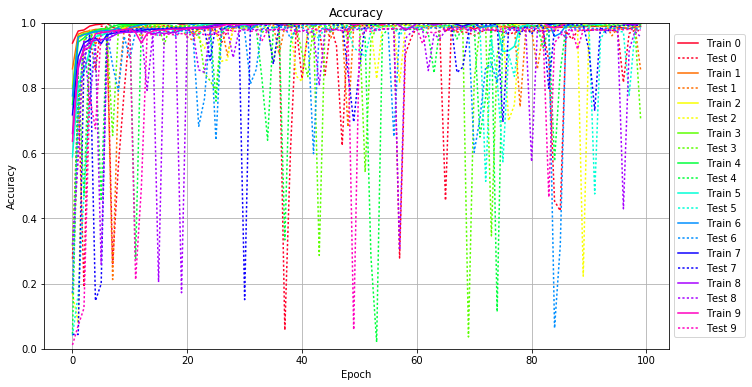

In [14]:
plot_acc(history)

In [15]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

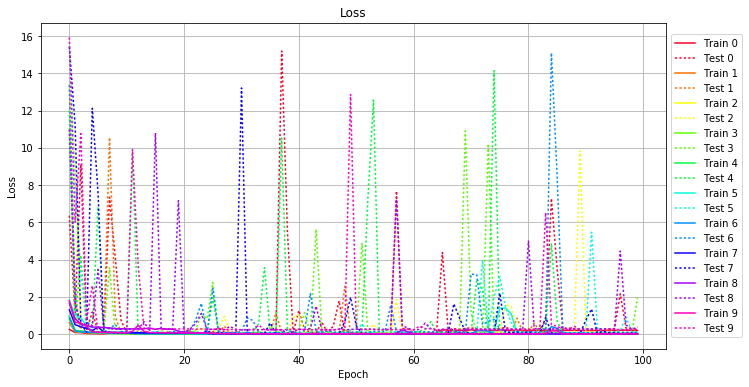

In [16]:
plot_loss(history)

Plotting the confusion matrix


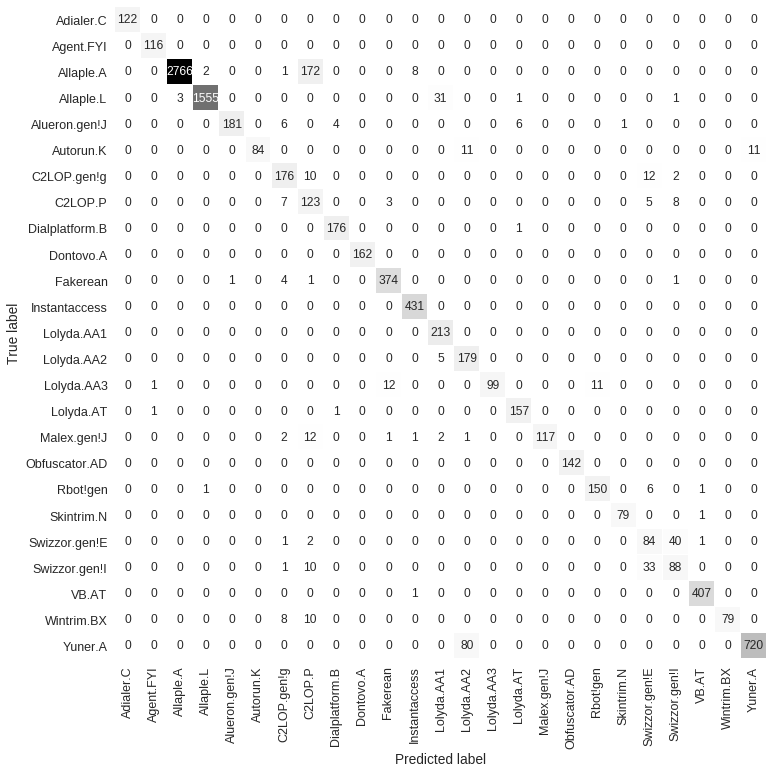

In [17]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


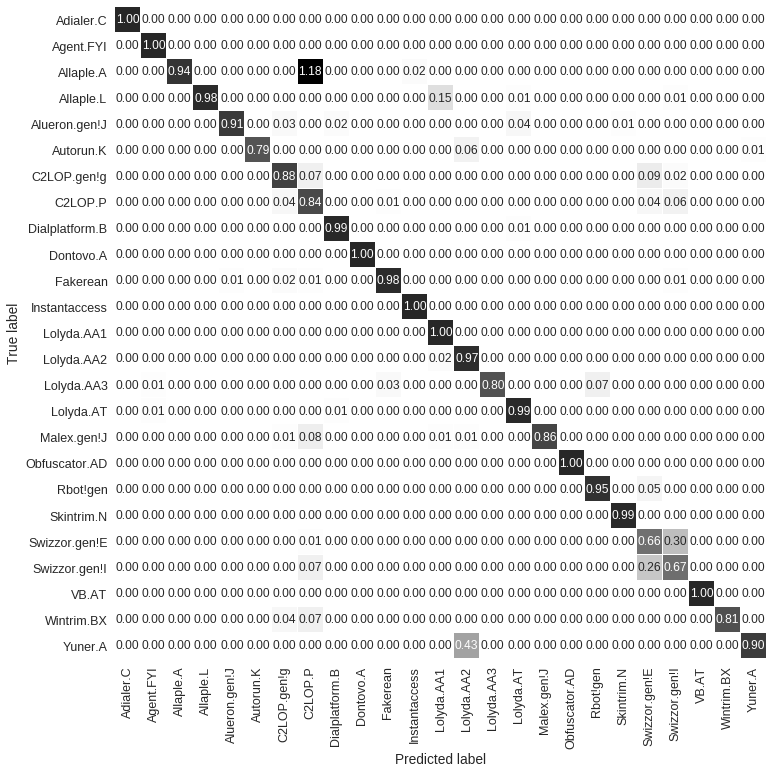

In [18]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [19]:
for h in history:
    print(h.history)

{'acc': [0.93733619251846556, 0.97438646652370742, 0.97760304979747437, 0.98939718846795333, 0.99356683345246599, 0.99535382416011442, 0.99809387657850845, 0.98546580891112701, 0.97962830590440575, 0.98367881817507519, 0.99070764832022873, 0.99642601858470337, 0.99737908029544908, 0.99880867286156783, 0.99880867286156783, 0.99511555873242796, 0.99880867286156783, 0.99964260185847031, 0.99916607097469401, 0.99344770073862287, 0.99725994758160585, 0.99880867286156783, 0.99845127472003814, 0.99904693826085078, 0.99166071003097456, 0.99952346914462709, 0.99797474386466523, 0.99725994758160585, 0.99928520371694063, 0.99964260185847031, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9918989754586609, 0.98880152489873718, 0.99654515127014309, 0.99594948772933045, 0.99642601858470337, 0.99880867286156783, 0.99940433643078386, 0.99904693828925428, 0.99976173457231354, 0.99845127472003814, 0.99809387657850845, 0.99761734572313554, 0.99976173457231354, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99666428401238982

In [20]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

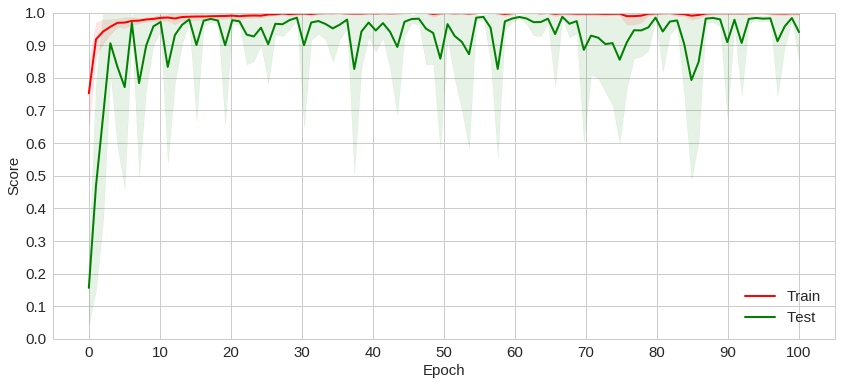

In [21]:
plot_mean_acc(history)

In [22]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

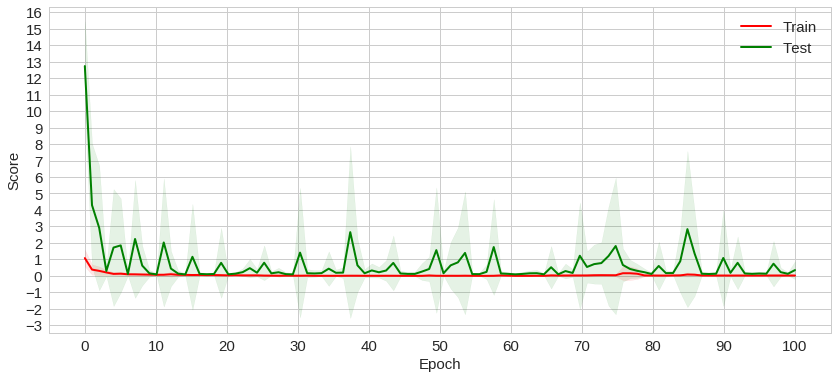

In [23]:
plot_mean_loss(history)

In [25]:
hist = [{'acc': [0.93733619251846556, 0.97438646652370742, 0.97760304979747437, 0.98939718846795333, 0.99356683345246599, 0.99535382416011442, 0.99809387657850845, 0.98546580891112701, 0.97962830590440575, 0.98367881817507519, 0.99070764832022873, 0.99642601858470337, 0.99737908029544908, 0.99880867286156783, 0.99880867286156783, 0.99511555873242796, 0.99880867286156783, 0.99964260185847031, 0.99916607097469401, 0.99344770073862287, 0.99725994758160585, 0.99880867286156783, 0.99845127472003814, 0.99904693826085078, 0.99166071003097456, 0.99952346914462709, 0.99797474386466523, 0.99725994758160585, 0.99928520371694063, 0.99964260185847031, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9918989754586609, 0.98880152489873718, 0.99654515127014309, 0.99594948772933045, 0.99642601858470337, 0.99880867286156783, 0.99940433643078386, 0.99904693828925428, 0.99976173457231354, 0.99845127472003814, 0.99809387657850845, 0.99761734572313554, 0.99976173457231354, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99666428401238982, 0.99642601858470337, 0.9991660710030974, 0.99964260185847031, 0.99988086728615677, 1.0, 0.99988086728615677, 0.99976173458651529, 0.97414820109602096, 0.98570407433881346, 0.98725279967558222, 0.98355968548963546, 0.98832499405756602, 0.97998570404593532, 0.98749106504646178, 0.9884441267572075, 0.98868239215649056, 0.98832499405756602, 0.98772933048834988, 0.98558494162497023, 0.98772933048834988, 0.98367881820347869, 0.9884441267572075, 0.98856325947105073, 0.98868239218489395, 0.98868239218489395, 0.98582320705265669, 0.98534667619728378, 0.98558494162497023, 0.98689540144884225, 0.98689540144884225, 0.98641887062187272, 0.98796759587343119, 0.98856325947105073, 0.98868239218489395, 0.98856325944264734, 0.98868239218489395, 0.98868239218489395, 0.98558494163917199, 0.98379795093152367, 0.98153442935430069, 0.98665713602115579, 0.98820586132952104], 'loss': [0.24821853806318619, 0.078206448055304939, 0.071286524713886176, 0.030775561100610926, 0.018555551782549529, 0.014691814884029937, 0.0061295554644187648, 0.04501632964409389, 0.068291669088813678, 0.046437543127747921, 0.024897237455485999, 0.0088245172799388035, 0.0079610929297949436, 0.004916752867401562, 0.0037501365439431538, 0.012314735117377499, 0.0040721087518472325, 0.0020441305989114464, 0.0028286392707956003, 0.022741627461377471, 0.0075195703865400601, 0.0036990472377503806, 0.0037162730751650616, 0.0030711513819025524, 0.033953229378472172, 0.0023439602898996325, 0.0059145788237605921, 0.0081796693555674094, 0.0020296638223623524, 0.0012586785577309613, 0.0003544562945440375, 0.00012867568181265836, 5.4405213207896445e-05, 4.3139489585026581e-05, 7.2764023558357261e-05, 2.8552324557138106e-05, 3.8332030275821162e-05, 0.030354458325110002, 0.035886310843570204, 0.010212076184964364, 0.012183585481700208, 0.0098541540020339758, 0.0033995797823108678, 0.001764111263689724, 0.0037106037153217097, 0.00094440644093244839, 0.0061221050908459793, 0.006605890773401569, 0.0071400684736782011, 0.0011758931929450351, 0.00021631339823428335, 0.00012974082946904923, 0.00013663723780875655, 6.1161323959777698e-05, 4.0597340395306727e-05, 4.3545451634909115e-05, 2.0132209115335948e-05, 0.011378571678933313, 0.011101311173013368, 0.0024926817198688525, 0.0012551314917550842, 0.00037686057584271202, 0.0001699019273933446, 0.00024665696447344424, 0.0021451922115189124, 0.24930398246561392, 0.19093787269838211, 0.18870935497631366, 0.20043234718434932, 0.18632176958966282, 0.22026976578181473, 0.18691133989405034, 0.18347942912443788, 0.18274991889657935, 0.18476468262925352, 0.18747723248907341, 0.19258262378438296, 0.18752073045062315, 0.19897498460546445, 0.18341518271252191, 0.18336100515109938, 0.18265209614170791, 0.18253666288946016, 0.1980248112518336, 0.19390898145832514, 0.20447589658137888, 0.18948164086422256, 0.19063043995570211, 0.19645645794548694, 0.18416819297467912, 0.18321608370089509, 0.18257066535022815, 0.18444271927890166, 0.18246952608168196, 0.1824571210916254, 0.19731584564011975, 0.20150507829090339, 0.20634872959225167, 0.19018946219021968, 0.18372811700016237], 'val_acc': [0.27619047619047621, 0.79047619047619044, 0.18941798941798943, 0.9555555555555556, 0.85502645502645502, 0.98941798941798942, 0.98518518518518516, 0.26137566137566137, 0.562962962962963, 0.78835978835978837, 0.98730158730158735, 0.99153439153439149, 0.98518518518518516, 0.99047619047619051, 0.98095238095238091, 0.98518518518518516, 0.99153439153439149, 0.99153439153439149, 0.97460317460317458, 0.97883597883597884, 0.98412698412698407, 0.97989417989417993, 0.99047619047619051, 0.98941798941798942, 0.98306878306878309, 0.97460317460317458, 0.93968253968253967, 0.97460317460317458, 0.98730158730158735, 0.98095238095238091, 0.99153439153439149, 0.99365079365079367, 0.99259259259259258, 0.99365079365079367, 0.99365079365079367, 0.99470899470899465, 0.99470899470899465, 0.057142857142857141, 0.61481481481481481, 0.98835978835978833, 0.82857142857142863, 0.96613756613756618, 0.97460317460317458, 0.98730158730158735, 0.83915343915343921, 0.98941798941798942, 0.92910052910052909, 0.62328042328042332, 0.98730158730158735, 0.98730158730158735, 0.99259259259259258, 0.98941798941798942, 0.99153439153439149, 0.99259259259259258, 0.99259259259259258, 0.99153439153439149, 0.99365079365079367, 0.27830687830687828, 0.9026455026455027, 0.95343915343915342, 0.98624338624338626, 0.99153439153439149, 0.98730158730158735, 0.99047619047619051, 0.96931216931216935, 0.455026455026455, 0.97989417989417993, 0.97142857142857142, 0.97142857142857142, 0.96931216931216935, 0.96084656084656084, 0.97037037037037033, 0.97777777777777775, 0.97671957671957677, 0.97460317460317458, 0.97248677248677251, 0.964021164021164, 0.97037037037037033, 0.97248677248677251, 0.97566137566137567, 0.97460317460317458, 0.97566137566137567, 0.97566137566137567, 0.8835978835978836, 0.45291005291005293, 0.42328042328042326, 0.97354497354497349, 0.94920634920634916, 0.97354497354497349, 0.97671957671957677, 0.97566137566137567, 0.97883597883597884, 0.97777777777777775, 0.97671957671957677, 0.97671957671957677, 0.97142857142857142, 0.81693121693121695, 0.96719576719576716, 0.97671957671957677, 0.97460317460317458], 'val_loss': [6.354330021489865, 1.0148583211630524, 9.1221534930839745, 0.17408191107013929, 1.180495412791611, 0.094873373019184096, 0.071930348072413039, 7.3430643678972958, 4.124215409093634, 0.74016752924525886, 0.051268144310681295, 0.039510353809783794, 0.059253578161900487, 0.048494686111720149, 0.08837729075347607, 0.045622470156326901, 0.047992880143974903, 0.038975577665515418, 0.12790906220445861, 0.092993419360900401, 0.13089088642227489, 0.12033295308786619, 0.046336421064639609, 0.07375867336568695, 0.073364409458664973, 0.10585051971005639, 0.34213292713143995, 0.10529154234444105, 0.07048857208670338, 0.11990988333679126, 0.052747539845596873, 0.052660329110447865, 0.052870305698631034, 0.052367360947432197, 0.054830532605293199, 0.053317833887730939, 0.050661467487342786, 15.197061391356129, 5.477445442966685, 0.067875125585203783, 1.2616606101157173, 0.16364696268289455, 0.11113854640375562, 0.073203898041009102, 0.6383152800545282, 0.053253913733773056, 0.42494783843339301, 1.7795169658372216, 0.041527726056761659, 0.046586969103550209, 0.041522740994708054, 0.051860542201321282, 0.046441402318079167, 0.053257302106465516, 0.052793939717140879, 0.052195036633005773, 0.05291211322191644, 7.6758212512388591, 0.29740974481595833, 0.26537774754516252, 0.068018166570403049, 0.049730733682688169, 0.080205644079715102, 0.057248550201743985, 0.14606661271361465, 4.3794902888555374, 0.23719377200915684, 0.27660342168642538, 0.26791083171581648, 0.29627752989942019, 0.33236716563601115, 0.25939216021302258, 0.24665885289405629, 0.24409311505352418, 0.25694161797289772, 0.28016873969925599, 0.35492150601413514, 0.25418225172884784, 0.26929826851981625, 0.26511603341929174, 0.26129091892924206, 0.25405383642982565, 0.25796262885361926, 0.70619712822020997, 7.2772132733511565, 3.4975059428543012, 0.26072595183365771, 0.31839591613978013, 0.27612903150868423, 0.26167517794966305, 0.2616887503159358, 0.26329559910435046, 0.26450264693644215, 0.26592377957965579, 0.26520340758167055, 0.29478298262964009, 2.1559690595961887, 0.31604164586992711, 0.26295926342260767, 0.26141978509800035]},
{'acc': [0.85852090032154338, 0.96463022517976238, 0.97165654411028579, 0.97487197818678872, 0.97927831378993324, 0.97975467438781294, 0.98261283801768073, 0.97808741217101347, 0.97808741217101347, 0.98380373953012568, 0.9816601168077248, 0.98630463260688339, 0.98261283801768073, 0.98535191139692746, 0.98773371452119385, 0.98832916517803981, 0.98809098497492731, 0.98749553411932833, 0.98630463260688339, 0.98701917362792357, 0.98225556757814392, 0.96546385613909724, 0.97963558413719187, 0.98487555079194955, 0.98368464937888112, 0.98701917351435031, 0.992497320471597, 0.99821364777392263, 0.98177920695896925, 0.99392640228653095, 0.99773728712635468, 0.99892818873817613, 0.99964272954626654, 0.99940454924377753, 0.99988090984875555, 0.99940454924377753, 0.99928545919190959, 0.99642729546266529, 0.99738001677199772, 0.99892818863879962, 0.99880909848755506, 1.0, 1.0, 0.99952363950149692, 0.99928545909253308, 0.99642729546266529, 0.99916636894128852, 0.99845182814029654, 0.96784565926336374, 0.99416458258901985, 0.99738001678619437, 0.99547457425270935, 0.99738001677199772, 0.99880909848755506, 0.99928545909253308, 0.99976181969751099, 1.0, 0.99940454924377753, 0.99940454924377753, 0.99988090984875555, 1.0, 0.99952363942341538, 0.99773728722573118, 0.99547457435208586, 0.99880909848755506, 0.99916636894128852, 0.99785637727759913, 0.99571275455519825, 0.99892818874527445, 0.99869000833631061, 0.99964272954626654, 0.99976181969751099, 0.99988090994813206, 0.99749910682386567, 0.99869000843568712, 0.99964272954626654, 0.99988090984875555, 1.0, 0.99702274621888765, 0.9955936644039538, 0.99904727879004407, 0.99964272956046318, 0.98082648564963681, 0.98630463270626001, 0.98713826366559487, 0.99333095162968499, 0.99607002500893171, 0.99952363939502198, 0.99964272954626654, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99904727888942058, 0.99666547576515419, 0.99928545909253308, 0.99988090984875555, 1.0, 0.99904727879004407], 'loss': [0.61177498846713796, 0.11362473666756667, 0.089259219684955177, 0.0754430743281055, 0.061644374436958499, 0.061639345170834865, 0.055286164067324478, 0.074837643717261135, 0.067913963723068391, 0.04963959630889752, 0.052377249046892185, 0.044276002926266843, 0.053987427128061191, 0.046977100752997686, 0.040580447579535384, 0.038331482795461863, 0.038558520017329519, 0.039073571039930942, 0.044211937519589149, 0.044151024385617715, 0.058817601269932893, 0.12267008645783205, 0.06139627707097535, 0.048041642136313706, 0.049852681331042807, 0.041079663138956848, 0.020732634356565933, 0.0091313934543413924, 0.064663845096331371, 0.018701625087737827, 0.010412701602175174, 0.0057536836182730776, 0.002404455088126224, 0.0023792389815927109, 0.0013396186568802343, 0.0020244564832329684, 0.0029253828501431085, 0.010519095703440843, 0.0087153190488535436, 0.0040531181554206239, 0.0030191334146250745, 0.00064622898613697437, 0.00056045559896766763, 0.0045477724725751425, 0.0037423055999877882, 0.010144338339124204, 0.0037035357567008769, 0.0061827557902837281, 0.21958630841579857, 0.019832168031198624, 0.012987338100438339, 0.016571697362597018, 0.009254882152073509, 0.0046231032394798439, 0.0019698161898503721, 0.0016285672511522676, 0.00049122513365837872, 0.0013649141391047107, 0.0021768394562448855, 0.0011683864535927898, 0.00028808382665716282, 0.0064694940565319823, 0.0089573574265018521, 0.014151431781053365, 0.0063689946390631464, 0.0048468802129668781, 0.0065371598095093058, 0.014696410868356928, 0.0071466865461974399, 0.0031223035532676859, 0.0013067021402336, 0.00094304947647102166, 0.00042391673234232923, 0.0071847172299915928, 0.0061279485285178096, 0.001218603265082624, 0.00054946514520718955, 0.00038651626082022989, 0.021085685666319701, 0.013315175969452659, 0.0023711968359712357, 0.0028752840194575602, 0.073781158968160093, 0.044509405321459888, 0.04036891002665393, 0.020846613745360492, 0.013914808440175782, 0.0017230345745183544, 0.0008467118573031692, 0.00022179446516239546, 0.00014360835123712918, 8.6384872788399447e-05, 0.00013806803912165373, 0.00015504327233886942, 0.0023800453784480671, 0.0090409034145074296, 0.0042712462136000624, 0.00058613845864223936, 0.00014582030325256798, 0.0041025258010233675], 'val_acc': [0.16878980891719744, 0.65817409766454349, 0.93842887473460723, 0.97664543524416136, 0.93205944798301488, 0.97983014861995754, 0.97027600849256901, 0.21231422505307856, 0.80148619957537159, 0.97770700636942676, 0.97346072186836519, 0.97770700636942676, 0.95647558386411891, 0.97770700636942676, 0.97876857749469215, 0.97876857749469215, 0.97664543524416136, 0.96709129511677283, 0.97346072186836519, 0.97983014861995754, 0.95647558386411891, 0.94585987261146498, 0.9713375796178344, 0.97558386411889597, 0.97876857749469215, 0.97239915074309979, 0.98726114649681529, 0.89915074309978771, 0.98301486199575372, 0.99150743099787686, 0.9861995753715499, 0.98726114649681529, 0.98726114649681529, 0.99150743099787686, 0.99044585987261147, 0.99256900212314225, 0.90339702760084928, 0.98832271762208068, 0.98726114649681529, 0.98938428874734607, 0.9851380042462845, 0.98938428874734607, 0.99044585987261147, 0.98726114649681529, 0.97983014861995754, 0.95329087048832273, 0.98726114649681529, 0.9851380042462845, 0.68046709129511673, 0.98938428874734607, 0.98832271762208068, 0.9851380042462845, 0.9861995753715499, 0.98938428874734607, 0.99150743099787686, 0.98938428874734607, 0.99044585987261147, 0.98938428874734607, 0.97983014861995754, 0.98938428874734607, 0.99044585987261147, 0.98726114649681529, 0.98089171974522293, 0.99044585987261147, 0.9861995753715499, 0.99150743099787686, 0.9861995753715499, 0.97346072186836519, 0.9861995753715499, 0.97558386411889597, 0.98832271762208068, 0.98938428874734607, 0.9861995753715499, 0.98726114649681529, 0.98301486199575372, 0.99044585987261147, 0.99150743099787686, 0.99044585987261147, 0.7420382165605095, 0.97770700636942676, 0.97876857749469215, 0.8577494692144374, 0.9713375796178344, 0.97664543524416136, 0.97452229299363058, 0.99150743099787686, 0.9861995753715499, 0.99044585987261147, 0.98938428874734607, 0.99044585987261147, 0.99044585987261147, 0.99044585987261147, 0.98938428874734607, 0.99256900212314225, 0.95966029723991508, 0.98301486199575372, 0.97876857749469215, 0.98938428874734607, 0.99044585987261147, 0.85456475583864122], 'val_loss': [13.397525179917647, 2.1898037433118089, 0.17996542533808393, 0.072305357850885307, 0.19336237088483182, 0.062512473511955421, 0.086686850195224624, 10.551025004270477, 0.93805128971862184, 0.067766607526468306, 0.066755174430857253, 0.053221461668935537, 0.16115520697449395, 0.065721504206100831, 0.064439034841920664, 0.062328454171571977, 0.063149112590340603, 0.12083907557841471, 0.072397583067590199, 0.072435251142322896, 0.12970877660337135, 0.19190699165796926, 0.080729677125113586, 0.072649962481857983, 0.06633005309267051, 0.073091208806012234, 0.069914934939201492, 0.42891877321496746, 0.05009946299352816, 0.023853479710890007, 0.036630892022204362, 0.03950641783370934, 0.034797803439110049, 0.030042081957018879, 0.029273546179576015, 0.03310091173192431, 1.1507015642347334, 0.048152523550436713, 0.041238219903115374, 0.02126440363601834, 0.049311119241796632, 0.037274802749686912, 0.040839661051415337, 0.046815088998111543, 0.1123587550853954, 0.27056371440815935, 0.055842349121625501, 0.052729677900574423, 2.5620767936316158, 0.035583986206030274, 0.03312939494613474, 0.064520724686182349, 0.035173694505134037, 0.034766626195738205, 0.041423370978598141, 0.037642649820370723, 0.035243857389064166, 0.033192382946357721, 0.056042154699897977, 0.036893225002230141, 0.035445887045820239, 0.045351902183882666, 0.063783435178521378, 0.049912951236275399, 0.0538968238141916, 0.035796851126866237, 0.062480592689037731, 0.083407605897939996, 0.049992144363727918, 0.14063190376670975, 0.069931895800563387, 0.056624876161933548, 0.048964576868484426, 0.034574566427376739, 0.069495403149406873, 0.043379339775267783, 0.03438759914850055, 0.036018856633853492, 0.85050581171001349, 0.10311284349116215, 0.1038873671561861, 0.58491865702427759, 0.12985737890108898, 0.095353477899451797, 0.10588796753153322, 0.028422841807615284, 0.041824976293753362, 0.03415749714849977, 0.043379907253478983, 0.038448947165978874, 0.038812421508954552, 0.037365537440467819, 0.042254078634750322, 0.041425262133575447, 0.27876704161991156, 0.098040303429870759, 0.064686291411137659, 0.035413539775257026, 0.042505384343641199, 0.38833970877292895]},
{'acc': [0.80680871324842285, 0.94952981787882396, 0.96309963102468976, 0.96798000250837801, 0.97262230687532492, 0.97488394238781095, 0.97833591239138196, 0.97666944412798584, 0.980240447565766, 0.98428758481133194, 0.99369122724194792, 0.99583382930603503, 0.994405427925247, 0.99619092965123202, 0.99726223070101294, 0.99678609689322695, 0.99726223068682296, 0.99845256517081304, 0.99869063206761099, 0.99904773241280798, 0.99845256517081304, 0.99726223068682296, 0.98833472205689799, 0.9854779193095119, 0.98523985239852396, 0.99761933104620992, 0.99297702654445896, 0.99619092965123202, 0.99940483275800496, 0.99952386633411305, 0.995714795857636, 0.99880966551601003, 0.99976193310320205, 0.99892869896440895, 0.99916676586120701, 0.99952386621349898, 0.99952386620640399, 0.99988096655160097, 0.99988096655160097, 0.99690513046933504, 0.99333412688965594, 0.99702416379002501, 0.99845256517081304, 0.99928579930960604, 0.99952386620640399, 0.99952386620640399, 0.99988096655160097, 0.99988096655160097, 0.99988096655160097, 0.99988096655160097, 0.99988096655160097, 0.99988096655160097, 0.99952386634830293, 0.99131055826687298, 0.99607189620283298, 0.99916676586120701, 0.99988096655160097, 0.99869063206761099, 0.99083442447327696, 0.99833353172241401, 0.99976193310320205, 0.99976193310320205, 0.99964289965480302, 0.99976193310320205, 0.99964289978251208, 0.996548029996429, 0.99857159861921196, 0.99988096655160097, 0.99976193310320205, 0.99988096655160097, 0.99988096655160097, 0.99976193310320205, 0.99988096655160097, 0.99988096655160097, 0.99988096655160097, 0.99976193311029693, 0.99619092977894108, 0.99369122723485304, 0.99761933103202005, 0.99964289965480302, 1.0, 1.0, 1.0, 1.0, 0.99916676586120701, 0.99904773241280798, 0.999761933230911, 1.0, 1.0, 0.99547672896083794, 0.99726223068682296, 0.99952386620640399, 0.99988096655160097, 0.99964289965480302, 0.99976193310320205, 0.99988096655160097, 0.99988096655160097, 1.0, 1.0, 0.99988096655160097], 'loss': [0.78695735129596589, 0.18355442082480353, 0.11334518786200937, 0.10083168232253642, 0.086472761674823262, 0.074787923705895709, 0.067975386741288765, 0.067520539028533028, 0.060249947109913174, 0.047099839388453281, 0.02006015327919056, 0.014958356904772091, 0.016836316169235921, 0.013354206076796458, 0.014295812376613327, 0.010618369856237595, 0.010547783249886497, 0.0082452051499950513, 0.0055938058339270874, 0.0052335740761815215, 0.0057261224320120001, 0.01132634777038677, 0.043684800797442629, 0.05314777183640558, 0.047102463934510688, 0.012095174775622389, 0.021607223949832458, 0.013888686620995603, 0.0045445298159792176, 0.003523790444867789, 0.016673182323521669, 0.0060635249290978714, 0.0026565969749893334, 0.0045414504370799415, 0.0042646354780740943, 0.0046232501980931198, 0.0039665970946056424, 0.0021213823831206656, 0.0020114854498529617, 0.0093879629120022616, 0.026235163640907409, 0.010825621841012035, 0.0060312862525958031, 0.004648263477820924, 0.0029132811363710301, 0.0029611963183448112, 0.0023357266042875512, 0.0020451086595343676, 0.0020118201712462994, 0.0019844334550125566, 0.0020088209121427942, 0.0020707770825710669, 0.0058299150259093413, 0.041668837053421143, 0.013407107641968782, 0.0040152370084421667, 0.0024274617278228234, 0.0065837877439974954, 0.036440407056117272, 0.0070425609957072925, 0.0034630617746694049, 0.0029134843327469104, 0.0030231652900375673, 0.0024246228845975883, 0.0028454986798648846, 0.014134177382785546, 0.0047394593307879306, 0.0023779247975518345, 0.0024354596419874394, 0.0022612830923639297, 0.0020985246724458053, 0.0022620917246350502, 0.0020626291373142839, 0.0019931994595752895, 0.0019949970935875497, 0.0021795369253876538, 0.013186252362075363, 0.022232813629160013, 0.0081605858408479344, 0.0010725658149475477, 0.0002518135215715727, 0.00021711663103897395, 9.0550955866386767e-05, 0.00012021433788132852, 0.0024326030822774286, 0.0024210052645690298, 0.0023975699611415487, 0.0002145742774251532, 9.8187670136145537e-05, 0.022251428963274027, 0.0083823731828515415, 0.0015520795082718799, 0.00072147984191129027, 0.0023829769344107755, 0.00085596554941443038, 0.0022381757199243929, 0.0021040138458285397, 6.9832178233337707e-05, 4.8813963002482758e-05, 0.00025472726019759638], 'val_acc': [0.16950959488272921, 0.077825159914712158, 0.95202558635394452, 0.97654584221748397, 0.9658848614072495, 0.97441364605543712, 0.98081023454157779, 0.97654584221748397, 0.97867803837953093, 0.97547974413646055, 0.98294243070362475, 0.99040511727078895, 0.98933901918976541, 0.98720682302771856, 0.98720682302771856, 0.9925373134328358, 0.98614072494669514, 0.99147121535181237, 0.98187633262260132, 0.99040511727078895, 0.9925373134328358, 0.97654584221748397, 0.95415778251599148, 0.9211087420042644, 0.97228144989339016, 0.98187633262260132, 0.88166311300639655, 0.88592750533049036, 0.98933901918976541, 0.98614072494669514, 0.97867803837953093, 0.99147121535181237, 0.98933901918976541, 0.97974413646055436, 0.99040511727078895, 0.98720682302771856, 0.99360341151385922, 0.99360341151385922, 0.9925373134328358, 0.83582089552238803, 0.8198294243070362, 0.9850746268656716, 0.94456289978678043, 0.98933901918976541, 0.98827292110874199, 0.99147121535181237, 0.98933901918976541, 0.99040511727078895, 0.99147121535181237, 0.99147121535181237, 0.99147121535181237, 0.99147121535181237, 0.99040511727078895, 0.82835820895522383, 0.98614072494669514, 0.98827292110874199, 0.98827292110874199, 0.81556503198294239, 0.98400852878464817, 0.98400852878464817, 0.99147121535181237, 0.99040511727078895, 0.98614072494669514, 0.98933901918976541, 0.98827292110874199, 0.98400852878464817, 0.99040511727078895, 0.99147121535181237, 0.99040511727078895, 0.99040511727078895, 0.99040511727078895, 0.99147121535181237, 0.98933901918976541, 0.98933901918976541, 0.98933901918976541, 0.99040511727078895, 0.6993603411513859, 0.74840085287846481, 0.98081023454157779, 0.99040511727078895, 0.99040511727078895, 0.99040511727078895, 0.99040511727078895, 0.98933901918976541, 0.98187633262260132, 0.98933901918976541, 0.98400852878464817, 0.99040511727078895, 0.98720682302771856, 0.22281449893390193, 0.99040511727078895, 0.97547974413646055, 0.99040511727078895, 0.99147121535181237, 0.98081023454157779, 0.98933901918976541, 0.99040511727078895, 0.99040511727078895, 0.99147121535181237, 0.98294243070362475], 'val_loss': [13.385923601162714, 8.9870065717554812, 0.14050633923363076, 0.083920037413615658, 0.086521755565883221, 0.08568151599028459, 0.078338914252976496, 0.078871134005801646, 0.086940500891453693, 0.077491761147749499, 0.055518122408653239, 0.052883854339072216, 0.053906534251041922, 0.074520106925596186, 0.054077520667618305, 0.04869550782081717, 0.081871161625205205, 0.044753225931259459, 0.063193461930185407, 0.054497720787614397, 0.041395600743265829, 0.12465397560591751, 0.15766495358611735, 0.33097860695927284, 0.097167807769304948, 0.099092513536245361, 0.28960445582990035, 0.95016806510769758, 0.069473446726738997, 0.076601017531034279, 0.093835663158163038, 0.058737130734229148, 0.070412760319044365, 0.090906063109721449, 0.057022996573047956, 0.063400892821911317, 0.065740289476141148, 0.065449749697531187, 0.064828435841604193, 0.89414591892266959, 1.0429098889745838, 0.077173682181403885, 0.21309203633247911, 0.061490544976703351, 0.056165548711657715, 0.059924538197094417, 0.068578209209650687, 0.065812441083391363, 0.065480114856999047, 0.065087547605259949, 0.062752843825556334, 0.071408008583356553, 0.074386359209702282, 0.51570206948085384, 0.078181539891707577, 0.068630549247856998, 0.071885626077049444, 1.8500080158318646, 0.078536720257899068, 0.069723352225366728, 0.063412705070099856, 0.069888815204335736, 0.068427977993121322, 0.067125483032657515, 0.070297050034778194, 0.079914347547935374, 0.078285497081016953, 0.076155967512519213, 0.077495362154336778, 0.068817282141227232, 0.069359305365942564, 0.069065991477737634, 0.068810052337895819, 0.069348705213158751, 0.068540013049833176, 0.066916780805436948, 1.5921540617772034, 1.4669047260266816, 0.11069002280685773, 0.067142570576638402, 0.066276689119739537, 0.068109970552909405, 0.070552290389674671, 0.075135710156311472, 0.10790800498972709, 0.078967325242361719, 0.10073313550105159, 0.076701786435565328, 0.081588191478321886, 9.8283937368819974, 0.10648795573129512, 0.14963147572724295, 0.092339310827998955, 0.070551309080629371, 0.092907215478710656, 0.072183800682736068, 0.075083949890706117, 0.07600732423114967, 0.075439990655578978, 0.12351994684826256]},
{'acc': [0.7976913007259312, 0.95787218850410571, 0.96691657741282877, 0.9696536951230762, 0.97167678210163033, 0.97536594073545158, 0.97857907890039275, 0.97560395096989172, 0.98679043198857552, 0.99166964179459716, 0.99452576460787812, 0.99416874925621801, 0.99333571343567773, 0.99678686188471166, 0.99583482089729858, 0.99678686183505893, 0.99619183624895868, 0.9980959181244794, 0.99833392835891943, 0.99880994882779961, 0.99976198976555997, 0.99797691300725933, 0.9980959181244794, 0.99595382601451865, 0.99119362132571698, 0.99654885160061879, 0.99785790789003925, 0.99880994882779961, 0.99988099488277993, 1.0, 1.0, 1.0, 1.0, 0.9984529334761395, 0.9980959181244794, 0.99726288230393911, 0.99381173395421074, 0.9980959181244794, 0.99892895394501968, 0.99940497441389975, 0.99916696417945972, 0.99904795906223964, 0.99928596929667979, 0.99892895394501968, 0.99940497446355259, 0.99797691300725933, 0.99976198976555997, 0.99988099488277993, 0.99928596929667979, 1.0, 1.0, 0.99452576460787812, 0.99559681066285854, 0.99976198976555997, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99012257527073666, 0.99393073902177798, 0.99952397953111982, 0.99988099488277993, 0.99773890277281918, 0.99488277995953822, 0.9984529334761395, 0.99964298464833989, 0.99988099488277993, 1.0, 0.99964298464833989, 0.99988099488277993, 1.0, 1.0, 1.0, 1.0, 0.99988099488277993, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99988099493243277, 0.9934547185528978], 'loss': [0.77603181018072354, 0.14333658816372016, 0.099413558793758822, 0.093339751501048188, 0.080289896195890734, 0.071420275623172325, 0.066971480340345418, 0.07104545355279375, 0.03645256920678034, 0.023746801628477941, 0.01798611122597903, 0.017152210036341715, 0.017455524335702119, 0.0085387537380015224, 0.015233997361075944, 0.010789289730500709, 0.015310586249947017, 0.0050554798148081679, 0.0053277635036813199, 0.0037167866477782912, 0.0013920339415957976, 0.0065591601064927656, 0.0047307549571967778, 0.011568580107395669, 0.050919558914561382, 0.011497110959754683, 0.0049815816277219462, 0.0044262392143369781, 0.0010303026608307914, 0.00030620224351557906, 0.00033450222449702972, 0.00016920642538365132, 0.00025192388552737835, 0.0057987239279685869, 0.0063935047951442156, 0.01118079927731312, 0.016988219609126089, 0.0068785532116484305, 0.0034691771441739436, 0.0021798050255230897, 0.0024825321556148951, 0.0031824741330439776, 0.0030622263368829047, 0.003803381940368113, 0.0016210042753512437, 0.0055747967557027347, 0.0012404486950085742, 0.00051020379229174153, 0.0027255345068582814, 0.0003505286864938596, 0.00016452708169598061, 0.018006510898474427, 0.013613006054825183, 0.00097276117832562937, 0.0003676424284035333, 0.00022200802445424317, 0.00013458069407360412, 6.3739375147074694e-05, 6.0553186179048694e-05, 5.2303501322822966e-05, 4.5157603066988621e-05, 4.919792345014732e-05, 6.7979345326431303e-05, 4.1251441498305548e-05, 2.8289677583881784e-05, 2.3901511744924987e-05, 1.9685620595224927e-05, 1.1760183187531636e-05, 2.6017275516523114e-05, 0.032741282001509275, 0.024324812527467109, 0.0022977365500027576, 0.0005781910023499484, 0.020289512293991868, 0.033396380269074488, 0.003587059994756244, 0.0025136547734409716, 0.00052284315305348562, 0.00028984707364269988, 0.0010206933016996165, 0.00072874180269048275, 0.00013891873134295237, 0.00010651691958077232, 5.8591999763728837e-05, 6.37571495893854e-05, 0.00032275179911677571, 6.6112708109149313e-05, 4.3888513042080259e-05, 6.8765912955285084e-05, 6.9542007007020309e-05, 4.5504547513428072e-05, 1.6656821690331165e-05, 2.6655889666043206e-05, 1.7068640956180543e-05, 1.182546096510114e-05, 1.1569337552936849e-05, 1.4535388018552382e-05, 7.0440927940491473e-06, 0.00047967831056286138, 0.027003564262866514], 'val_acc': [0.31517094017094016, 0.7350427350427351, 0.94764957264957261, 0.94978632478632474, 0.97756410256410253, 0.9604700854700855, 0.96901709401709402, 0.65384615384615385, 0.97970085470085466, 0.98824786324786329, 0.99145299145299148, 0.98931623931623935, 0.98290598290598286, 0.99038461538461542, 0.99358974358974361, 0.98717948717948723, 0.93269230769230771, 0.99038461538461542, 0.98611111111111116, 0.99038461538461542, 0.98931623931623935, 0.98611111111111116, 0.97329059829059827, 0.84401709401709402, 0.82158119658119655, 0.78846153846153844, 0.99038461538461542, 0.97970085470085466, 0.99145299145299148, 0.99252136752136755, 0.99145299145299148, 0.99145299145299148, 0.99252136752136755, 0.96901709401709402, 0.98290598290598286, 0.87606837606837606, 0.97649572649572647, 0.97970085470085466, 0.99038461538461542, 0.98931623931623935, 0.90705128205128205, 0.83440170940170943, 0.99252136752136755, 0.28632478632478631, 0.98931623931623935, 0.97222222222222221, 0.99358974358974361, 0.99465811965811968, 0.94658119658119655, 0.99038461538461542, 0.99145299145299148, 0.54166666666666663, 0.94551282051282048, 0.98611111111111116, 0.98824786324786329, 0.98931623931623935, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.98931623931623935, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.036324786324786328, 0.82264957264957261, 0.98611111111111116, 0.98611111111111116, 0.34615384615384615, 0.90277777777777779, 0.97649572649572647, 0.98931623931623935, 0.99038461538461542, 0.99038461538461542, 0.99038461538461542, 0.99145299145299148, 0.99038461538461542, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.99038461538461542, 0.99038461538461542, 0.99038461538461542, 0.99038461538461542, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.98931623931623935, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.99145299145299148, 0.98611111111111116, 0.70405982905982911], 'val_loss': [11.038140150216913, 1.2254850393495498, 0.12600250964311646, 0.12443717017483252, 0.071112267644160509, 0.11014488463513414, 0.077968098011273801, 3.5681327693482752, 0.062476023353980038, 0.034460250201068722, 0.0268724173446315, 0.032370103385576054, 0.037451287405011913, 0.028070084261997134, 0.015504950660724562, 0.029061489076559512, 0.22840495269453182, 0.024779094230045581, 0.040585815857722883, 0.027983109414503621, 0.026039915559063709, 0.071545438048403423, 0.20406063979912609, 1.0730962896501699, 0.8306244864251916, 2.759792169442592, 0.030486071831765594, 0.091646838208499171, 0.025819943226533491, 0.027481706904257632, 0.033191578554821806, 0.034059373508144884, 0.026383051699708514, 0.11763053684536184, 0.066745179920633002, 0.51771218959806586, 0.084959268803317195, 0.11238780334188149, 0.05876955052079786, 0.031151261054880246, 0.29189183668974233, 1.1467902296119266, 0.023386099604685556, 5.6171182694598141, 0.030840675379412343, 0.12612216253709113, 0.032857340570200753, 0.02931346045558314, 0.21778775000164713, 0.03359274981935647, 0.038903639532512975, 4.8628407418569051, 0.18209529365630123, 0.04031341799024777, 0.034205967237209506, 0.033421819982030761, 0.034368277838397923, 0.037278803829792775, 0.03771587852791463, 0.038123178089296619, 0.042082379793055638, 0.04970770117368311, 0.044204694777724429, 0.042383487002487542, 0.041080646178974348, 0.042193577226502271, 0.043661312213334802, 0.044629533730439416, 0.042959233238100886, 10.907313607696794, 1.1330309360005546, 0.044004359517012988, 0.037820374874658037, 10.206946764236845, 0.33241787639104475, 0.19662802563950527, 0.040791441520643193, 0.040638221126092472, 0.032880524439604, 0.037734242266188676, 0.051093093539160965, 0.042243829825058046, 0.041537261347916632, 0.043042951348038885, 0.043663146591903693, 0.044029184275942157, 0.046139826916074107, 0.047407767591406302, 0.048992224857850777, 0.042841885295427713, 0.04428237694370072, 0.044962663592474986, 0.059692983877863696, 0.051731047118335927, 0.051460043655521474, 0.050421032278530467, 0.051005800264386628, 0.050859504612173034, 0.05495650804402654, 1.9450783930812507]},
{'acc': [0.74916706324644966, 0.94050452159961484, 0.95323655402189433, 0.96989528801485447, 0.97584483579247983, 0.98108043791509025, 0.97965254637810351, 0.98798191337458352, 0.99321751546882442, 0.99476439790575921, 0.9936934792955735, 0.99416944309395305, 0.99547834364588295, 0.99631128034269401, 0.99845311756306521, 0.99797715373631601, 0.99797715373631601, 0.9978581627796288, 0.99797715373631601, 0.99904807234650161, 0.99952403617325081, 0.99988100904331267, 1.0, 0.99988100904331267, 1.0, 0.98988576868158018, 0.99393146120894815, 0.99773917182294147, 0.99726320799619228, 0.99857210851975253, 0.99940504521656359, 0.99976201808662546, 0.99845311756306521, 0.99714421703950495, 0.99678724416944309, 0.99845311756306521, 0.99904807234650161, 0.99619228935763704, 0.99416944312232269, 0.9989290813898144, 0.99726320799619228, 0.9989290813898144, 0.99976201808662546, 0.99928605425987627, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99928605425987627, 0.99631128034269401, 0.98988576868158018, 0.99845311753469557, 0.99881009043312707, 0.99952403617325081, 0.99988100904331267, 0.99988100904331267, 1.0, 1.0, 0.99988100904331267, 0.9978581627796288, 0.99714421703950495, 0.99881009043312707, 0.99940504521656359, 0.99964302712993813, 0.99976201808662546, 0.99976201808662546, 0.99833412660637788, 0.99964302712993813, 0.99881009043312707, 0.99881009043312707, 1.0, 0.99809614469300334, 0.99940504521656359, 0.99988100904331267, 0.99976201808662546, 0.99881009043312707, 0.99976201808662546, 0.99988100904331267, 1.0, 0.99940504521656359, 0.99809614469300334, 0.99619228935763704, 0.99678724416944309, 0.99881009043312707, 0.99976201808662546, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.95685744186289701, 0.19968623040631406, 0.15860221838168109, 0.090228255566870919, 0.06858416828196115, 0.065372695200418302, 0.056548158792882573, 0.034313430472399889, 0.021610399401183287, 0.016072095941863235, 0.016813058906794659, 0.017100005743955073, 0.014337050215962181, 0.01022293867839448, 0.006415359107161323, 0.006107947886210008, 0.0061231247930861642, 0.0053069732148157715, 0.004877807368300075, 0.0029128810567634771, 0.0021907554213389953, 0.00098645010027105344, 0.00027055669504894687, 0.00049817120892110757, 0.0002119166865664047, 0.032612033940374388, 0.020360037029832991, 0.0059997728392561589, 0.01036116953747261, 0.0046212025759595383, 0.0023557679087700938, 0.001026077414994132, 0.0037292994496236566, 0.0086306938817875302, 0.0089482859154405552, 0.0061512004662284507, 0.0028484321823489915, 0.016146604476333894, 0.019907533576081063, 0.0048168440999796546, 0.0073298662681433868, 0.0040268500957818436, 0.0019600371598927765, 0.0014170587479321066, 0.00038847196566412846, 0.00017140782938072726, 0.00013309759434135216, 9.3303658497187995e-05, 8.6830237010510333e-05, 6.6815660930318345e-05, 6.053854923187692e-05, 0.0015956993485225883, 0.012272316745178409, 0.036657202802687132, 0.0066896031327192797, 0.0037648806991283064, 0.0016641670256946856, 0.0008070786525496181, 0.00051190314957487936, 0.00020143463816614128, 0.00011479333920057396, 0.00068970538903462622, 0.007894253121507884, 0.0078514806613685564, 0.0033362306303600436, 0.0037114559724494172, 0.00089227911368794702, 0.0011165502074366909, 0.0011467788695926628, 0.0070839655466844505, 0.00253673544239345, 0.0036927609779022963, 0.0035402634497221047, 0.00072076088912129393, 0.0064705215884358295, 0.0019763950045411497, 0.00068767886019185183, 0.00064217544758464592, 0.0038079850031649469, 0.0012611130232207562, 0.00030186686416562727, 0.00012791251803506227, 0.0010613506329051725, 0.005088064695422485, 0.0087668196489337803, 0.013217244221368869, 0.0041058422668191433, 0.00086774881993711213, 0.00024211844833308866, 0.00011904679329162174, 7.9154961672319246e-05, 6.8590727989352102e-05, 4.6170552633338437e-05, 3.2425245244589246e-05, 2.8448836895541521e-05, 2.8464467659791853e-05, 6.8962812160708418e-05, 2.7709914231697818e-05, 1.9495777791332848e-05, 1.5548209020809444e-05], 'val_acc': [0.044919786096256686, 0.84491978609625673, 0.46844919786096256, 0.97540106951871652, 0.91229946524064176, 0.45347593582887702, 0.98930481283422456, 0.99358288770053471, 0.98716577540106953, 0.9882352941176471, 0.99144385026737969, 0.27486631016042778, 0.99358288770053471, 0.99037433155080212, 0.98716577540106953, 0.9882352941176471, 0.98716577540106953, 0.99037433155080212, 0.98930481283422456, 0.98930481283422456, 0.98930481283422456, 0.99144385026737969, 0.99251336898395726, 0.99144385026737969, 0.99251336898395726, 0.75935828877005351, 0.96577540106951876, 0.98930481283422456, 0.9850267379679144, 0.98930481283422456, 0.98609625668449197, 0.99251336898395726, 0.98395721925133695, 0.8310160427807487, 0.63957219251336894, 0.98395721925133695, 0.99144385026737969, 0.3336898395721925, 0.93796791443850269, 0.9850267379679144, 0.99037433155080212, 0.99144385026737969, 0.98930481283422456, 0.99251336898395726, 0.99251336898395726, 0.99144385026737969, 0.99144385026737969, 0.99251336898395726, 0.99144385026737969, 0.99251336898395726, 0.99251336898395726, 0.95294117647058818, 0.28449197860962566, 0.020320855614973262, 0.96042780748663104, 0.98074866310160425, 0.97967914438502679, 0.97860962566844922, 0.97860962566844922, 0.97967914438502679, 0.97967914438502679, 0.97860962566844922, 0.96684491978609621, 0.84598930481283419, 0.9850267379679144, 0.99144385026737969, 0.99144385026737969, 0.94973262032085559, 0.9882352941176471, 0.99037433155080212, 0.99144385026737969, 0.64919786096256682, 0.77112299465240641, 0.99144385026737969, 0.11336898395721925, 0.99251336898395726, 0.99358288770053471, 0.99358288770053471, 0.97540106951871652, 0.98930481283422456, 0.99037433155080212, 0.99144385026737969, 0.92299465240641709, 0.98181818181818181, 0.57540106951871661, 0.85240641711229947, 0.98609625668449197, 0.99144385026737969, 0.99251336898395726, 0.99037433155080212, 0.99144385026737969, 0.99144385026737969, 0.99251336898395726, 0.99251336898395726, 0.99358288770053471, 0.99251336898395726, 0.99144385026737969, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726], 'val_loss': [11.995669465906479, 0.59227404823915208, 4.224917025107116, 0.080122726997497548, 0.2449720257378985, 6.8143479298780338, 0.037185799715829845, 0.024831109830848196, 0.026229228879814409, 0.026868264258024906, 0.031678455048046956, 9.6946116230883632, 0.019505655916225776, 0.024857474794287963, 0.03021640575090111, 0.02440141517093734, 0.030641431275775087, 0.034949902234610607, 0.046431880957765494, 0.034233941586904029, 0.032583103775918561, 0.019011374656249372, 0.02265645143633262, 0.023928205669039197, 0.018997917529528535, 1.9366721736865784, 0.091214396808400378, 0.0289978078745949, 0.060076238553056535, 0.034502885649342403, 0.052876250943172443, 0.028465975885072908, 0.054043550454838732, 0.55484298336964577, 3.5697380455545722, 0.049057233351225034, 0.028958773961550985, 10.526748804102612, 0.20600263995675525, 0.034893314771786213, 0.029842194025812518, 0.031546025316813886, 0.027679951985118093, 0.019451068839068046, 0.02113328338228921, 0.020370848422807564, 0.022691206658105888, 0.021599349485158088, 0.023079412572127315, 0.023895190069027895, 0.021892466855703233, 0.20972150826608979, 7.1547737175130592, 12.561555919545219, 0.23276532977100561, 0.19596950490180423, 0.14885698380635562, 0.10280289918092203, 0.090189328298133739, 0.098561037588164868, 0.0914448583446483, 0.1514147427029704, 0.24845297553643203, 0.66677484241219043, 0.064730611809843255, 0.04353578750307463, 0.033115003575358792, 0.19618548670663644, 0.042604628029901725, 0.049705273208188079, 0.031391992974032605, 2.9682796674960623, 2.3836081519653725, 0.032954130199809098, 14.138662156701725, 0.034553671267184505, 0.037119930107777289, 0.026060929417930891, 0.16988787826750185, 0.047044989981865043, 0.03949265828533513, 0.034063410053820228, 0.45385664947815046, 0.11271818172914463, 4.8734142806880607, 0.68543748578353736, 0.057916809430102349, 0.037663196668725571, 0.034326732886722888, 0.036299769358382562, 0.035917658169277743, 0.034427152973354296, 0.035284255732465332, 0.03662578323762869, 0.036895548267508127, 0.038599333767784821, 0.0395969801784627, 0.039577103769147942, 0.040669003314419409, 0.04147316186169097]},
{'acc': [0.58852927180371473, 0.81211327944750566, 0.84983341271737711, 0.91313660161827703, 0.95728224657763195, 0.96144693003331749, 0.96918134221799146, 0.97370299851536923, 0.97346501665873397, 0.97524988098067367, 0.97536887196573063, 0.97715373631603997, 0.97703474535935264, 0.97905759162303663, 0.97977153736316036, 0.98060447405997142, 0.98072346501665875, 0.98131841977172551, 0.98167539267015702, 0.98250832933859844, 0.98381722986215869, 0.98381722986215869, 0.99000475960989787, 0.99607329842931935, 0.99583531651594481, 0.99750118988119718, 0.99619228938600668, 0.99857210851975253, 0.99940504521656359, 0.98833888621627575, 0.99238457877201336, 0.9978581627796288, 0.99750118990956682, 0.99881009043312707, 0.99928605425987627, 0.99869109947643975, 0.99904807234650161, 0.99797715370794637, 0.9989290813898144, 1.0, 1.0, 0.99988100901494303, 0.99607329842931935, 0.99393146120894815, 0.99714421703950495, 0.99916706330318894, 1.0, 0.99976201808662546, 0.99976201808662546, 0.99916706330318894, 0.99809614469300334, 0.99833412660637788, 0.99809614469300334, 0.99678724416944309, 0.9989290813898144, 1.0, 0.99952403617325081, 0.99964302712993813, 0.99869109947643975, 0.99869109947643975, 0.99821513564969067, 0.99976201808662546, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98726796760609015, 0.9904807234650167, 0.98833888621627575, 0.91147072828139419, 0.91396953828671845, 0.92741551642075204, 0.98798191337458352, 0.9915516420752023, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99535935268919562, 0.99535935268919562, 0.99845311756306521, 0.99952403617325081, 0.99940504521656359, 0.997263207939453, 0.99833412660637788, 1.0, 0.99988100904331267], 'loss': [1.814493830007692, 1.0056807871718227, 0.86393079072279566, 0.42927654876042581, 0.130480832270019, 0.11207812802882945, 0.091766528689481139, 0.077768125296036217, 0.079905399654604942, 0.072936886615664664, 0.070645526051521301, 0.066541866395358293, 0.065112838937392517, 0.060549417188810427, 0.06071133928143839, 0.057504184887181967, 0.057857696346181493, 0.05265705164757755, 0.054571427881845345, 0.051440839779371313, 0.048681901798879233, 0.046591602748118938, 0.028234504006345574, 0.015194543307039378, 0.011592173877959874, 0.0078356828984282711, 0.0089194894375610664, 0.0045775579530076401, 0.0031709462007630026, 0.047701751761540047, 0.024071069569373483, 0.0072016493993137974, 0.0069594068041245061, 0.0045738282280666899, 0.002896382355913369, 0.0046765380624053587, 0.0034775843003449799, 0.005522467516697784, 0.003844528751325231, 0.00077578914255487365, 0.0004199780245759932, 0.00023812679318802144, 0.013666157400130699, 0.017970216995282902, 0.010715850891290199, 0.0029435905206641882, 0.00069471005087599566, 0.0013446875461865914, 0.0021054482915989371, 0.0023329815320133245, 0.0064184935729401449, 0.0045866298911608865, 0.0059799434180666626, 0.0083527402794437954, 0.0035542968404407294, 0.00055849922875836507, 0.0021024306055804948, 0.0012445054432024371, 0.0032736295639904196, 0.0033084727209492472, 0.0068107548438998671, 0.0011679168490654243, 0.0001740318067826591, 0.00012285448455289763, 6.8805951135482836e-05, 5.8003226988701754e-05, 3.5169816583532057e-05, 4.7252651040269561e-05, 7.1642718250603215e-05, 0.00024216321880846556, 4.5243321016972147e-05, 4.3070321186575979e-05, 0.045869772514926459, 0.030199372858675227, 0.14144829454685942, 1.3891552730380552, 1.3824246190718843, 1.0807619732669398, 0.040497312092642054, 0.02723565599789133, 0.00082933207945052624, 0.00025805291994399472, 0.00023499826184784336, 0.00012100003500630714, 9.4720451745471787e-05, 0.0001675725304075626, 8.1725520502057465e-05, 7.555534011035762e-05, 5.5778286070860726e-05, 3.9592976084400734e-05, 4.521739595577677e-05, 0.027122978579801595, 0.01643343036503964, 0.0055218908632362973, 0.0018083747152581736, 0.0025548154013499023, 0.0078296941947021293, 0.005465023122750423, 0.00066063266610179826, 0.00033587728108871236], 'val_acc': [0.040641711229946524, 0.16684491978609625, 0.46951871657754013, 0.76791443850267382, 0.96363636363636362, 0.95935828877005347, 0.96684491978609621, 0.96470588235294119, 0.96898395721925135, 0.9732620320855615, 0.97112299465240637, 0.97005347593582891, 0.97112299465240637, 0.97540106951871652, 0.97219251336898393, 0.95935828877005347, 0.9732620320855615, 0.9732620320855615, 0.97647058823529409, 0.97433155080213907, 0.96684491978609621, 0.97219251336898393, 0.96042780748663104, 0.9882352941176471, 0.98395721925133695, 0.98609625668449197, 0.99358288770053471, 0.98609625668449197, 0.98609625668449197, 0.9850267379679144, 0.98288770053475938, 0.98181818181818181, 0.99251336898395726, 0.98716577540106953, 0.99251336898395726, 0.98288770053475938, 0.98716577540106953, 0.98716577540106953, 0.9850267379679144, 0.99358288770053471, 0.99144385026737969, 0.99358288770053471, 0.96898395721925135, 0.94973262032085559, 0.99037433155080212, 0.98181818181818181, 0.99144385026737969, 0.99037433155080212, 0.9882352941176471, 0.92085561497326207, 0.91229946524064176, 0.89518716577540103, 0.97219251336898393, 0.98181818181818181, 0.9882352941176471, 0.99144385026737969, 0.9850267379679144, 0.96042780748663104, 0.98288770053475938, 0.98609625668449197, 0.9850267379679144, 0.9882352941176471, 0.99144385026737969, 0.99037433155080212, 0.98930481283422456, 0.99037433155080212, 0.99037433155080212, 0.99037433155080212, 0.99144385026737969, 0.99037433155080212, 0.99037433155080212, 0.99037433155080212, 0.5133689839572193, 0.94866310160427803, 0.82673796791443854, 0.57326203208556148, 0.90374331550802134, 0.83529411764705885, 0.98181818181818181, 0.9882352941176471, 0.99037433155080212, 0.99144385026737969, 0.98930481283422456, 0.99144385026737969, 0.99251336898395726, 0.99037433155080212, 0.99144385026737969, 0.98930481283422456, 0.98930481283422456, 0.99037433155080212, 0.99144385026737969, 0.4748663101604278, 0.946524064171123, 0.98609625668449197, 0.98609625668449197, 0.97433155080213907, 0.97112299465240637, 0.7775401069518717, 0.97112299465240637, 0.98716577540106953], 'val_loss': [15.463028435528598, 8.1681035312101802, 3.2784068291837527, 0.88950969337779573, 0.15851647982343953, 0.13105435845277766, 0.10114994976559982, 0.10138810647920492, 0.089388164279068552, 0.09868264302840446, 0.086495579945576884, 0.082252808539636707, 0.087530431458116439, 0.070354924417946885, 0.071432943785573078, 0.12835775878676337, 0.07666358723190618, 0.080152580181863858, 0.081275568226816752, 0.081704314909683967, 0.0890744634599272, 0.072259832412704214, 0.13989544594511052, 0.045031736662726848, 0.054368557826053092, 0.041680605980771258, 0.02725856819371867, 0.035552211230935944, 0.057850844465382273, 0.047767649150929285, 0.04647069298052154, 0.061938427181593141, 0.036426469562761209, 0.049987577249415535, 0.036319034195993756, 0.070489166763601105, 0.057091802328121798, 0.049341324833533005, 0.05380656391432255, 0.029753852644716972, 0.036488549755443425, 0.032419123383003561, 0.13002341843294127, 0.22243043246258173, 0.043691605673848485, 0.057206543268394479, 0.028398942952555097, 0.034627662860493263, 0.041410673460558413, 0.24353708226850468, 0.24126284351220037, 0.52986578100278758, 0.093132853054099379, 0.070405916494920756, 0.040864146706238419, 0.039688676789784355, 0.051987876511601618, 0.15173905100376039, 0.065721043462220227, 0.062599304120451171, 0.053077595419345022, 0.038024716787385754, 0.041183618174250203, 0.040760443278584947, 0.041196945634041256, 0.043000124945994526, 0.043709580885723971, 0.046036566515655651, 0.045534387216089302, 0.058136046629695834, 0.052763557007290317, 0.053681781046729285, 3.9705022419200224, 0.26487573270928044, 1.9737228733731464, 3.0715833761395617, 1.4259474854573713, 0.59950276944079883, 0.08407218453518038, 0.04659757145980397, 0.048049476617896603, 0.048208130606256415, 0.050519912032884598, 0.051557904965479767, 0.052260351441860226, 0.054070408436691871, 0.055486383391480605, 0.058897053786543509, 0.057240511041328455, 0.058765148958955883, 0.061773830917597701, 5.4648610471309542, 0.33904385987626257, 0.056127724563495754, 0.064601026913452333, 0.10798442945982602, 0.1920404702288501, 0.9137693781973445, 0.15426708162486516, 0.051598705103251291]},
{'acc': [0.77545195063673578, 0.95551855387175, 0.96313035215909537, 0.9677687916270219, 0.97276403425309232, 0.97431018078020937, 0.97585632730732641, 0.97704567078972404, 0.98358706005633612, 0.97383444338725023, 0.98477640348202156, 0.98929590865842054, 0.99393434823977167, 0.99643196955280688, 0.99797811607992393, 0.99821598477640339, 0.99916745956232156, 0.99678877259752618, 0.99833491912464323, 0.99726451010390993, 0.99714557564224549, 0.99417221693625124, 0.99797811607992393, 0.99678877259752618, 0.99881065651760226, 0.99904852521408183, 1.0, 1.0, 1.0, 1.0, 0.999643197011993, 0.97918648905803995, 0.9926260705225588, 0.99714557564224549, 0.99881065651760226, 0.99988106565176027, 0.99988106565176027, 1.0, 0.99952426260704086, 0.99952426260704086, 0.99869172216936253, 0.99881065651760226, 0.99238820171265463, 0.99857278782112269, 0.99976213130352043, 0.9992863939105614, 0.99916745956232156, 1.0, 1.0, 1.0, 0.99976213130352043, 0.99678877259752618, 0.99916745956232156, 0.99869172216936253, 0.99845385347288296, 0.9996431969552807, 0.99904852521408183, 0.99845385347288296, 1.0, 0.99988106565176027, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99845385358630756, 0.98453853478554199, 0.9877497621313035, 0.99048525214081828, 0.99916745956232156, 0.99952426260704086, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99988106576518487, 0.95801617518478521, 0.96681731689781603, 0.99167459562321603, 0.99666983824928634, 0.99904852521408183, 0.99916745956232156, 0.99988106565176027, 1.0, 0.99988106565176027, 0.99988106565176027, 0.99940532825880113, 0.9996431969552807, 1.0, 0.9996431969552807, 1.0, 0.99952426260704086], 'loss': [0.85899414614083991, 0.15411547859235677, 0.11272089188292864, 0.097570688609958947, 0.081867117353216112, 0.075239821573760149, 0.071019148034044494, 0.063152222510437866, 0.050321820382556955, 0.07333857884238891, 0.040085810013328074, 0.030426476822437615, 0.016749354247951952, 0.010941789668167699, 0.0083421289631263919, 0.0062810650254736212, 0.0039609741597278194, 0.011048241410883839, 0.0059485806724996785, 0.0083569837513678379, 0.0096094141441014566, 0.023443777852077623, 0.0066065791729934247, 0.0097674624822017189, 0.0037577571638671061, 0.0025997575373343635, 0.00060096868281394461, 0.00025955787199967185, 0.00023133820937700538, 0.00023446874279601075, 0.0046875550437727046, 0.094721050095167555, 0.021905852221865224, 0.009124738546666537, 0.0038717033873731095, 0.001603303027457135, 0.00083638654534304454, 0.00035709013945139397, 0.0016492078439157534, 0.0027941926447003387, 0.0030723588091328378, 0.0034642581576346879, 0.032838438122076243, 0.005173923153920696, 0.0013621856327670193, 0.0017318405969665217, 0.0020936032164065197, 0.00054694441744234041, 0.00023267686782657549, 0.00015280335455126356, 0.0004879998711279955, 0.0085144387918785185, 0.0023857764444342963, 0.0040771308998917575, 0.0045364690868345244, 0.0015112519480270749, 0.0024890706970215289, 0.0051650599245120239, 0.00062525854887674295, 0.00038794887501694469, 0.00020127036247740709, 7.1190266881551134e-05, 5.9318914847416427e-05, 5.587507586857242e-05, 4.7409121774456417e-05, 3.7429014362794567e-05, 3.1921784278292471e-05, 4.7792628654144372e-05, 3.1971018339636629e-05, 0.0001666182701770252, 0.0050726721568603019, 0.18154729761185034, 0.1870706181662492, 0.15408077420178667, 0.0038250727059587005, 0.0024239265207156879, 0.00034035127986781102, 0.00017448041191725621, 8.5030221801620464e-05, 9.3716977212858737e-05, 2.69477873202297e-05, 9.8491824964410928e-05, 4.7226357698684459e-05, 0.00012678382622163933, 0.39743501872411841, 0.29485689596956211, 0.03111299482883343, 0.010983061636955373, 0.0047334842350354751, 0.0028999888469932733, 0.0011682636484175435, 0.00068859886043535796, 0.0024977229935044293, 0.00076026679813128242, 0.0018587173474603664, 0.0014218914138863096, 0.00045698824468128372, 0.00067991629406152635, 0.00028754235465435325, 0.0011457536648828079], 'val_acc': [0.17078410311493017, 0.72610096670247049, 0.94092373791621908, 0.96992481203007519, 0.96885069817400649, 0.96885069817400649, 0.96992481203007519, 0.86895810955961328, 0.78947368421052633, 0.95810955961331901, 0.89044038668098824, 0.97422126745435011, 0.98388829215896889, 0.98281417830290008, 0.98174006444683137, 0.96992481203007519, 0.98174006444683137, 0.9860365198711063, 0.95810955961331901, 0.97636949516648763, 0.97529538131041893, 0.96348012889366275, 0.68206229860365197, 0.76691729323308266, 0.98174006444683137, 0.64017185821697098, 0.98496240601503759, 0.98496240601503759, 0.98711063372717511, 0.98496240601503759, 0.97529538131041893, 0.81203007518796988, 0.85606874328678839, 0.98174006444683137, 0.98281417830290008, 0.9860365198711063, 0.9860365198711063, 0.9860365198711063, 0.95166487647690656, 0.98281417830290008, 0.9860365198711063, 0.97314715359828141, 0.59828141783028999, 0.97744360902255634, 0.98496240601503759, 0.97207303974221271, 0.98281417830290008, 0.98496240601503759, 0.98496240601503759, 0.98496240601503759, 0.98281417830290008, 0.98174006444683137, 0.9860365198711063, 0.97529538131041893, 0.97959183673469385, 0.98174006444683137, 0.65091299677765846, 0.97851772287862515, 0.98388829215896889, 0.9860365198711063, 0.98496240601503759, 0.98388829215896889, 0.98388829215896889, 0.98388829215896889, 0.98496240601503759, 0.98388829215896889, 0.98496240601503759, 0.98496240601503759, 0.98496240601503759, 0.98496240601503759, 0.60257787325456502, 0.70676691729323304, 0.86251342642320084, 0.87325456498388832, 0.8152524167561761, 0.94844253490870034, 0.98281417830290008, 0.98281417830290008, 0.98388829215896889, 0.98496240601503759, 0.98496240601503759, 0.98281417830290008, 0.98388829215896889, 0.98066595059076267, 0.063372717508055856, 0.31793770139634803, 0.98711063372717511, 0.98388829215896889, 0.98281417830290008, 0.98281417830290008, 0.98174006444683137, 0.98281417830290008, 0.98066595059076267, 0.98174006444683137, 0.98281417830290008, 0.98174006444683137, 0.98281417830290008, 0.98281417830290008, 0.98281417830290008, 0.98174006444683137], 'val_loss': [13.365380956074095, 1.7888344183052027, 0.39391356551765822, 0.090863909912480709, 0.089162532998416949, 0.086522680223110118, 0.1018807628660877, 0.29004806968374486, 0.51351810336237014, 0.11725213008489811, 0.16539416195690892, 0.10384864600977503, 0.062013106476063576, 0.061376949458131887, 0.053270339561150855, 0.11066391652417579, 0.080260361586804385, 0.052255960155112011, 0.14472193715835183, 0.064766582714399251, 0.088002274388276847, 0.18009028564532295, 0.74137638225975411, 1.6455018959067178, 0.092953448506135641, 2.4483936848348979, 0.071498911557986544, 0.073233885062653659, 0.071258801863237423, 0.07732954935040981, 0.12690151278362682, 0.86040181830441442, 0.72158675395258665, 0.061579117258181298, 0.063650450832336308, 0.071206023206277003, 0.072241044040592547, 0.078543858886607157, 0.22315848998590063, 0.094609085917720409, 0.079805571993695951, 0.18587927934721984, 2.1801795033076403, 0.098996613052884708, 0.10655710690049744, 0.16492736858248744, 0.099092500530698319, 0.0993230700620788, 0.097304741754177165, 0.098404779778926685, 0.10056897613671645, 0.10807406756262895, 0.077115725057413903, 0.14654637814652491, 0.13419330599878046, 0.1245573239091444, 1.551064668469347, 0.1420362642177754, 0.10303897019273045, 0.11064779377028006, 0.11204955761225667, 0.11409762025462551, 0.11670825848103711, 0.11671776286984739, 0.11497051380429608, 0.11562766891409261, 0.11465397840971733, 0.11438446381823891, 0.11973039422660549, 0.10838162122961038, 3.2149594028837503, 3.1783286632374832, 0.5097622112336021, 0.67160344870499145, 0.77879793309221212, 0.25768251133614101, 0.10097984179121196, 0.10267837702146385, 0.10896364112566484, 0.11054561510551977, 0.11377281435528848, 0.11110631136226318, 0.11444242832583765, 0.12081981500403238, 15.096647866942572, 8.4548671652755978, 0.055654069132243418, 0.063684030173297559, 0.054749222775729613, 0.066807496076814632, 0.069360895888153418, 0.075362441178585121, 0.078720283293945648, 0.077939640775570418, 0.082113425091800835, 0.091134139186582086, 0.085717172859553506, 0.095680570495893721, 0.09080263956083004, 0.084806042372976315]},
{'acc': [0.71736028540290353, 0.895838287866073, 0.93769322256696064, 0.94780023781212841, 0.95338882304258499, 0.93555291319857314, 0.96302021422936146, 0.9671819263916378, 0.97134363862478779, 0.97336504161712245, 0.97288941736028534, 0.97586206906474016, 0.97621878725736799, 0.97883472057074916, 0.98014268727705112, 0.98014268737627408, 0.97978596908442328, 0.98121284195415759, 0.98323424494649225, 0.98263971462544586, 0.98347205707491081, 0.98513674207306356, 0.98442330578703097, 0.98620689655172411, 0.985731272294887, 0.99536266349583824, 0.99500594540243337, 0.99536266349583824, 0.99797859690844237, 0.99892984542211649, 0.99548156965927048, 0.99655172413793103, 0.99892984542211649, 0.99952437574316289, 0.99928656361474433, 0.99785969084423309, 0.99143876337693226, 0.99785969084423309, 0.99904875148632577, 0.99952437574316289, 0.99940546967895361, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99797859700766534, 0.99274673018245718, 0.99714625445897742, 0.99797859690844237, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9945303210463734, 0.98858501793513254, 0.99488703923900124, 0.99881093935790721, 0.99916765755053505, 0.99976218787158144, 1.0, 1.0, 0.99845422126450234, 0.99904875148632577, 0.99988109393579072, 0.99976218787158144, 1.0, 0.99988109393579072, 1.0, 1.0, 0.99429250891795484, 0.99667063020214031, 0.99964328180737216, 1.0, 0.99952437574316289, 1.0, 0.99952437574316289, 0.99667063020214031, 0.99738406658739598, 0.99928656361474433, 1.0, 1.0, 0.99976218787158144, 0.99952437574316289, 0.99988109393579072, 1.0, 1.0], 'loss': [1.2972835455014504, 0.49798276601591801, 0.39295610423320537, 0.30929409963976895, 0.18606589997140746, 0.37429825477169187, 0.10872185019406354, 0.088715306126405172, 0.07931947305213824, 0.073539329835797321, 0.074541918082023206, 0.066635772936692844, 0.065446980340089583, 0.061571115002868861, 0.057632416335247925, 0.059091229607460757, 0.057354605548509026, 0.051543222380166391, 0.05118819103021436, 0.052386130274281205, 0.050017707819710447, 0.047023958186580228, 0.046696485527630512, 0.044317703541727045, 0.041689457464188021, 0.016465709186419313, 0.014787169866370176, 0.012975756377070328, 0.006624292499550777, 0.004270138687096474, 0.012580332781136142, 0.010219164313244612, 0.0040405226735438036, 0.0022753827218337298, 0.0035590772735459926, 0.0057227114497326254, 0.028221209317791263, 0.0065623716237499657, 0.0033751714745687052, 0.0019996842403039857, 0.0026527135880714879, 0.00092346436016297012, 0.00033803096430974307, 0.00060362372871717565, 0.0002640211657999143, 0.00018534187190320485, 0.00030777864025265654, 0.00017576687644314969, 0.0057221170508644798, 0.026053660920202094, 0.0084389944362878253, 0.0078451018076691869, 0.00088443367719992451, 0.00036947349620793086, 0.00026854698724591245, 0.00023911771546607986, 0.00013114909450799022, 8.216755119026124e-05, 9.5855553961355082e-05, 0.00012639149536274033, 5.944088909091857e-05, 6.7286459717153592e-05, 6.4427810339306261e-05, 4.5973581024136215e-05, 4.1511243954712696e-05, 2.4817591376662033e-05, 5.8636668225141154e-05, 0.018452794331626287, 0.042301116141797386, 0.015688277872994736, 0.0037039061614849529, 0.0027245198053185466, 0.00096858861926343962, 0.00042325579349589577, 0.00056123760145148716, 0.0051655300339674476, 0.0029702050042069847, 0.00065572596243854673, 0.00066509181930513017, 0.00016860252990259753, 0.00025028768574844438, 0.00015688100683260489, 0.00022318515090236394, 0.020710838714640259, 0.0086187026336712377, 0.0012303511948160983, 0.0006407659336890362, 0.0015187872275894904, 0.00020996636100987961, 0.0019981585307653313, 0.010773186254185028, 0.0096969901305301101, 0.0022294916528582741, 0.00058200978573290439, 0.00066731990908758991, 0.00086513414475149068, 0.0016715884460149618, 0.00039554805804553275, 0.00012779947524595563, 9.8003153136544329e-05], 'val_acc': [0.044133476856835309, 0.044133476856835309, 0.87836383207750268, 0.96124865446716901, 0.14747039827771799, 0.19913885898815931, 0.95694294940796554, 0.9709364908503767, 0.97631862217438103, 0.97524219590958017, 0.97847147470398277, 0.9806243272335845, 0.98170075349838537, 0.97847147470398277, 0.9773950484391819, 0.98170075349838537, 0.9806243272335845, 0.98493003229278797, 0.9838536060279871, 0.98277717976318624, 0.97631862217438103, 0.9806243272335845, 0.9806243272335845, 0.98170075349838537, 0.88482238966630788, 0.9967707212055974, 0.97631862217438103, 0.98815931108719057, 0.99784714747039827, 0.98815931108719057, 0.15069967707212056, 0.9935414424111948, 0.99461786867599566, 0.99461786867599566, 0.99138858988159306, 0.87298170075349835, 0.9935414424111948, 0.99246501614639393, 0.99569429494079653, 0.98708288482238971, 0.9935414424111948, 0.9967707212055974, 0.9967707212055974, 0.99569429494079653, 0.9967707212055974, 0.9967707212055974, 0.99138858988159306, 0.9967707212055974, 0.84822389666307862, 0.69537136706135627, 0.86221743810548979, 0.99138858988159306, 0.99138858988159306, 0.99569429494079653, 0.9967707212055974, 0.99569429494079653, 0.9967707212055974, 0.9967707212055974, 0.99569429494079653, 0.9967707212055974, 0.99569429494079653, 0.99569429494079653, 0.99569429494079653, 0.9967707212055974, 0.99784714747039827, 0.9967707212055974, 0.99784714747039827, 0.84714747039827776, 0.86329386437029065, 0.96663078579117334, 0.9903121636167922, 0.99461786867599566, 0.99246501614639393, 0.99461786867599566, 0.99461786867599566, 0.69537136706135627, 0.9773950484391819, 0.98493003229278797, 0.96447793326157161, 0.9903121636167922, 0.96447793326157161, 0.99138858988159306, 0.99246501614639393, 0.79870828848223896, 0.98600645855758884, 0.99246501614639393, 0.99246501614639393, 0.9935414424111948, 0.99246501614639393, 0.99461786867599566, 0.91496232508073194, 0.72981700753498391, 0.98708288482238971, 0.96878363832077508, 0.98923573735199144, 0.98815931108719057, 0.99246501614639393, 0.9903121636167922, 0.99246501614639393, 0.99138858988159306], 'val_loss': [15.406747799515083, 11.260859354961546, 0.58307860693839186, 0.096928274878516268, 12.122951458293475, 7.5582563796264104, 0.11176090955252928, 0.082377137827996147, 0.065739276208032618, 0.070277759809519669, 0.072607190153895246, 0.062820178203363566, 0.058596815073214563, 0.058095164978642373, 0.06172713959398092, 0.05277508282450559, 0.05659049581951002, 0.050868287148701972, 0.053158785181743905, 0.050830179039919342, 0.059697371936103465, 0.059878471400007613, 0.049879500381994013, 0.047861370328010522, 0.19135054436681964, 0.017230447460847179, 0.076292333596518255, 0.037485899348177851, 0.0091930346181248075, 0.027637028237086733, 13.213492066020986, 0.015942302873957932, 0.020381777581664984, 0.020041959077537235, 0.024939457019260185, 0.58939237359465668, 0.015044642115685933, 0.020283290541291868, 0.012402209632683335, 0.041929437977859356, 0.014025846106880454, 0.012768987832917772, 0.0096667415806033982, 0.011997765685572107, 0.011938087825173641, 0.014740002264419162, 0.020359682394153665, 0.013773594655218145, 0.66383502698945585, 1.9684989943393023, 0.44582668820194099, 0.019859739191898089, 0.020930624712535952, 0.01288148073025824, 0.012687919603203607, 0.01520397000329432, 0.012548076528623458, 0.014436088824090223, 0.015795742904694775, 0.012771266473886949, 0.011686767447814928, 0.015208157343961934, 0.017045919167060924, 0.017815920404326627, 0.016469452934676471, 0.016999865468561044, 0.015486636236554439, 1.620212663055598, 0.85052727113115401, 0.11580282082011478, 0.02946058299051485, 0.026728381376356948, 0.02543481955051587, 0.027425559862191189, 0.01138760950107834, 2.1938448069725922, 0.12744026458141794, 0.058218705853772319, 0.10951517542016949, 0.029850532315886347, 0.12508557231778841, 0.029487225358234309, 0.034197824038148958, 0.89737250955103376, 0.054181743996290735, 0.019969640237457311, 0.032614047492876545, 0.025092879982273983, 0.021536633650976897, 0.026644949076788989, 0.74146146533517043, 1.3402809875869905, 0.047199928436821796, 0.1423699982841278, 0.063476009908596739, 0.058662411382122776, 0.026461342506912264, 0.023991715977988347, 0.029809249908489356, 0.02506088841984324]},
{'acc': [0.66009032570440185, 0.85951984798593706, 0.92227240336431526, 0.94081293094291352, 0.94651770869428031, 0.94806275266860873, 0.95020204432537136, 0.95875921083907778, 0.96814832446239096, 0.97004991703201193, 0.97123841231187225, 0.97207035915228768, 0.97230805799857378, 0.9720703590389439, 0.96493938684973546, 0.96945566912289038, 0.9667221301237251, 0.96898027097694317, 0.97076301402424525, 0.9771808891078767, 0.98443071083357192, 0.98538150701212268, 0.9858569051580699, 0.98657000249033444, 0.99049203708105538, 0.99322557653359567, 0.99263132885116168, 0.99488947004441097, 0.98621345376753033, 0.99227478012835746, 0.99512716900404086, 0.99191823151889713, 0.99584026622296173, 0.99655336344188261, 0.99584026622296173, 0.99726646066080338, 0.99833610648918469, 0.99869265509864513, 0.99797955799306803, 0.9971476111243166, 0.9976230093836076, 0.9960779652959354, 0.99679106251485616, 0.9964345140187395, 0.99560256714998807, 0.99821725695269792, 0.99964345139053956, 0.99952460185405279, 0.99904920370810557, 0.99976230092702634, 1.0, 1.0, 0.99988115046351322, 0.99988115046351322, 0.99988115046351322, 0.99976230092702634, 0.99988115046351322, 0.99168053267261091, 0.97670549096192949, 0.98502495840266224, 0.99762300927026382, 0.99952460185405279, 0.99833610648918469, 0.99251247920133112, 0.99643451390539572, 0.99786070845658126, 0.99869265509864513, 0.99928690278107912, 0.99916805335793613, 0.99976230092702634, 0.99940575231756601, 0.99916805324459235, 1.0, 1.0, 0.99988115046351322, 0.99750415973377704, 0.99881150463513191, 0.99893035417161868, 0.99964345139053956, 0.99988115057685689, 0.99643451390539572, 0.99845495613901525, 0.99893035417161868, 0.99952460185405279, 0.99988115046351322, 0.99988115046351322, 0.99893035417161868, 0.99893035417161868, 0.99964345139053956, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99928690278107912, 0.99667221297836939, 0.99453292132160687, 0.99346327560656933, 0.99833610648918469], 'loss': [1.6578698645642287, 0.81304736515108189, 0.54666010158090883, 0.45640257546744156, 0.36954685877756238, 0.37265595265967222, 0.34637254759906616, 0.32806676993687134, 0.29032325721960156, 0.28114968457881079, 0.2723076190061855, 0.27266620669451069, 0.26570924405843799, 0.27837194597456161, 0.3186339734815945, 0.25178973379230341, 0.30055743179611449, 0.2469473982986985, 0.25777264546256734, 0.1598223898217121, 0.074755802320235418, 0.0912691552184446, 0.055357334741515433, 0.063027375638272432, 0.030096682666756421, 0.016504100315243585, 0.022020979376131455, 0.018092899588371701, 0.04473829952728655, 0.025422386171919185, 0.016865384452270933, 0.022995049476238677, 0.013955023741127484, 0.011764608335932991, 0.012814594231316138, 0.013225490278479165, 0.0073650111307180617, 0.0078987744865956291, 0.010462736901398796, 0.0097359895088763235, 0.012442566916751222, 0.014841063319878542, 0.011367142190798672, 0.02882918764644269, 0.024379378561344905, 0.0085006752201394285, 0.0019525081301385828, 0.0036781768920262563, 0.0057230419279520016, 0.0045622692432693759, 0.00057806289674428252, 0.00036286037897869392, 0.002170947871856867, 0.0021635386207218285, 0.0021465907690473292, 0.0040220594031611717, 0.002142110852861985, 0.037798463794112808, 0.22030283712268597, 0.12132949736088847, 0.013026696251659243, 0.0042183061057235937, 0.0058781148699843435, 0.040834168152821003, 0.01936507122758829, 0.013543451800697803, 0.0074360855467476275, 0.0033483314650548995, 0.0029777199068829058, 0.0023837439770010827, 0.0025345780155482003, 0.002158006811846005, 0.00065758447621605662, 0.00039965675365274305, 0.0010079979493409128, 0.0063084866362019239, 0.0029320417393019355, 0.0034610030751350556, 0.00091932000938656797, 0.00047272140580115841, 0.012582438787494018, 0.0047732521341375331, 0.0030968864273378917, 0.0020036284797505725, 0.00070655131834277275, 0.0006833370192032629, 0.0046033932078606878, 0.003180772271627978, 0.00168181909342317, 0.00024880501917454932, 0.00017788217380964409, 7.5788317818686584e-05, 0.00014314985975138195, 6.6381830870686041e-05, 8.8619827518142714e-05, 0.0020849243664444192, 0.009440032347165464, 0.019624083513819286, 0.028198549825240334, 0.0044722358177952636], 'val_acc': [0.31891891891891894, 0.5805405405405405, 0.94270270270270273, 0.75567567567567573, 0.93081081081081085, 0.25945945945945947, 0.92648648648648646, 0.96432432432432436, 0.97837837837837838, 0.97513513513513517, 0.96972972972972971, 0.97513513513513517, 0.97621621621621624, 0.79243243243243244, 0.96756756756756757, 0.20432432432432432, 0.97729729729729731, 0.96972972972972971, 0.96972972972972971, 0.17189189189189188, 0.97729729729729731, 0.97297297297297303, 0.85513513513513517, 0.84756756756756757, 0.97621621621621624, 0.9664864864864865, 0.97729729729729731, 0.97729729729729731, 0.89297297297297296, 0.9740540540540541, 0.97837837837837838, 0.98054054054054052, 0.97837837837837838, 0.97945945945945945, 0.97621621621621624, 0.97945945945945945, 0.97945945945945945, 0.97945945945945945, 0.98810810810810812, 0.97297297297297303, 0.97621621621621624, 0.96972972972972971, 0.97189189189189185, 0.80756756756756753, 0.97837837837837838, 0.97837837837837838, 0.97945945945945945, 0.97513513513513517, 0.98162162162162159, 0.97729729729729731, 0.98054054054054052, 0.98054054054054052, 0.98162162162162159, 0.97837837837837838, 0.98054054054054052, 0.98162162162162159, 0.97945945945945945, 0.30270270270270272, 0.9513513513513514, 0.96972972972972971, 0.97945945945945945, 0.98054054054054052, 0.85297297297297292, 0.96432432432432436, 0.95027027027027022, 0.97621621621621624, 0.97837837837837838, 0.97837837837837838, 0.9924324324324324, 0.9740540540540541, 0.97621621621621624, 0.97513513513513517, 0.97729729729729731, 0.97729729729729731, 0.97729729729729731, 0.97081081081081078, 0.97729729729729731, 0.97729729729729731, 0.97621621621621624, 0.97837837837837838, 0.57405405405405407, 0.9740540540540541, 0.97297297297297303, 0.97513513513513517, 0.97621621621621624, 0.97621621621621624, 0.9513513513513514, 0.97837837837837838, 0.97729729729729731, 0.97729729729729731, 0.97621621621621624, 0.97729729729729731, 0.97729729729729731, 0.97621621621621624, 0.97621621621621624, 0.97621621621621624, 0.42918918918918919, 0.91567567567567565, 0.97297297297297303, 0.95675675675675675], 'val_loss': [10.977729863347237, 1.6763669207289411, 0.34854586006821814, 0.62304076075553894, 0.44643180185073134, 3.4588902012077538, 0.39037422844284292, 0.28626118805655909, 0.24861774861007124, 0.25324765678117606, 0.26084186743693172, 0.24828676223468565, 0.25492360867830499, 0.66170517182027977, 0.13930059934781025, 10.793834231358298, 0.26434160835034137, 0.27947480628619326, 0.25000997427592958, 7.1576568551965662, 0.085491154063964972, 0.25544934238936451, 0.55551639722962232, 1.1037463953305111, 0.22879378630330935, 0.25354917943823729, 0.24149385739415979, 0.22662435565803379, 0.40879561722101615, 0.23496007718393427, 0.2257292737219187, 0.21474545434872486, 0.22231443519477506, 0.22608137589296612, 0.23705238072996632, 0.2275376936966092, 0.22106169052827229, 0.21987119933473767, 0.045399923657227975, 0.12046212890809968, 0.24327690429036306, 0.25774597313841474, 0.29176064775828775, 1.4901613143415346, 0.21783212790736889, 0.23530488552472151, 0.22722046602907811, 0.25537681553878772, 0.22076838503594667, 0.2435460205410532, 0.25589235570904428, 0.23269437312617319, 0.25098584838802857, 0.25105205764014671, 0.24795226810968146, 0.249212809966775, 0.24148639606417591, 7.2512731184810404, 0.47425530474305755, 0.29834642341038736, 0.22338361793828537, 0.2385691956360077, 0.58691951134958109, 0.27765451461753399, 0.16351105864876248, 0.24755493504655679, 0.2444065423281476, 0.23865612689315616, 0.049659584036275975, 0.24949869170706684, 0.24681837731014467, 0.26290274273358444, 0.25813455304847716, 0.25752737981686402, 0.25963756364122514, 0.26452968567671631, 0.25794108171144292, 0.25952756742426181, 0.26650504461012475, 0.23318587911980662, 4.9913607402115359, 0.28922895961144346, 0.28410750848349403, 0.25146455140727653, 0.26419229272542688, 0.28916705782424162, 0.38118463951248144, 0.23992199726573352, 0.26929149103215544, 0.27408456226157618, 0.26565432093961994, 0.26868742151327457, 0.26880315728571275, 0.26979734095935404, 0.27333509233149583, 0.25841358363915395, 4.4500961991702281, 0.48433703696032721, 0.26654160133553545, 0.34867453394468217]},
{'acc': [0.63640684410646386, 0.87202946768060841, 0.91753802281368824, 0.92419201520912553, 0.96554182509505704, 0.96898764258555137, 0.9713640684410646, 0.97492870722433456, 0.97576045627376429, 0.97813688212927752, 0.98075095057034223, 0.96946292775665399, 0.93738117870722437, 0.96673003802281365, 0.97385931558935357, 0.97706749049429653, 0.97718631178707227, 0.98015684410646386, 0.9799192015209125, 0.98015684410646386, 0.98075095057034223, 0.98372148288973382, 0.98300855513307983, 0.98134505703422048, 0.98384030418250945, 0.98597908745247154, 0.98942490494296575, 0.99548479087452468, 0.99429657794676807, 0.99643536121673004, 0.99762357414448666, 0.99560361216730042, 0.99786121673003803, 0.99809885931558939, 0.99631653992395441, 0.99857414448669202, 0.99762357414448666, 0.99596007604562742, 0.99893060836501901, 0.99524714828897343, 0.99714828897338403, 0.99833650190114065, 0.99881178707224338, 0.99798003802281365, 0.99916825095057038, 0.999643536121673, 0.99976235741444863, 0.999643536121673, 0.99988117870722437, 0.99382129277566544, 0.99631653992395441, 0.99691064638783267, 0.99881178707224338, 0.99833650190114065, 0.99465304182509506, 0.99904942965779464, 0.99976235741444863, 1.0, 1.0, 0.99988117870722437, 0.999643536121673, 0.99786121673003803, 0.99940589353612164, 0.99809885931558939, 0.99726711026615966, 0.99833650190114065, 0.99988117870722437, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98823669201520914, 0.98384030418250945, 0.98823669201520914, 0.99940589353612164, 0.99976235741444863, 0.99821768060836502, 0.99952471482889738, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.7841437701489988, 0.62067784397321057, 0.59332112922641256, 0.39301850326614235, 0.12167555535700839, 0.099875710507989379, 0.089681670282163548, 0.0780874845454958, 0.072742503171807915, 0.066969377488011184, 0.058221843376925687, 0.13973501331735927, 0.46535403918857354, 0.14262135484797647, 0.076975862555800731, 0.069262964473931057, 0.066984234483976321, 0.061797458051700331, 0.060512751546252817, 0.058824970553356434, 0.055460953745041966, 0.051124972390442974, 0.05167330332284531, 0.055292768467628456, 0.048515801618987615, 0.039027598475817833, 0.026314964223150234, 0.014392227833221237, 0.019339263736192464, 0.010496498069789228, 0.0077355837451865963, 0.011559989795847016, 0.010652276628065107, 0.0067633783827427806, 0.011221005044613713, 0.0052449246488924109, 0.0077109107177880743, 0.013198166779780711, 0.0041627776882626269, 0.015876177190440023, 0.0089970845559386396, 0.0059425064551041143, 0.004556407760742418, 0.0060861000850174346, 0.003632749311819393, 0.002444227333198312, 0.0013087806315117024, 0.0020617390103882067, 0.0013542921599906453, 0.020377031917940623, 0.013293222674503285, 0.011997665614303566, 0.0050548034739045841, 0.0054379827345140677, 0.017427571687062569, 0.0044925532294289002, 0.0014970512835659926, 0.00053588197154467467, 0.00047352669943507387, 0.00038919657877314515, 0.00079828413716299831, 0.0086513335105344227, 0.0037218551212871275, 0.0078033030172765692, 0.0079997678962580414, 0.0050011702727916175, 0.0010359343724777239, 0.00057980818124951661, 0.00024103886753852087, 0.0002157455672605524, 0.00021988685198733317, 0.00012635754182547005, 8.8662647393498564e-05, 6.3237966099883338e-05, 4.9361312520793346e-05, 5.2428161559514194e-05, 4.0098535101388243e-05, 3.0633421700158337e-05, 2.7066766327363384e-05, 4.6135159614839261e-05, 3.4220348629182443e-05, 2.1114073604815464e-05, 9.5822396010174744e-05, 0.041546935393659688, 0.172987759199074, 0.15856069828397568, 0.0031291587847832635, 0.0013824870138982243, 0.0062293081901864441, 0.002020531206937255, 0.00044606818982738123, 0.00021227247849766993, 0.00018029866018169315, 0.00010359402729231591, 7.919047102889016e-05, 6.842701834782154e-05, 7.1339654600913611e-05, 6.4039402529674877e-05, 3.7273788397467401e-05, 4.4205636998036019e-05], 'val_acc': [0.011917659804983749, 0.071505958829902488, 0.12459371614301191, 0.77248104008667384, 0.67497291440953411, 0.97291440953412789, 0.9707475622968581, 0.97291440953412789, 0.971830985915493, 0.97941495124593714, 0.97724810400866735, 0.21235102925243771, 0.49404117009750814, 0.96208017334777896, 0.96424702058504874, 0.96099674972914406, 0.96533044420368364, 0.96424702058504874, 0.96208017334777896, 0.96641386782231853, 0.96208017334777896, 0.96424702058504874, 0.96641386782231853, 0.96316359696641385, 0.96316359696641385, 0.96641386782231853, 0.96099674972914406, 0.97941495124593714, 0.97399783315276278, 0.97291440953412789, 0.98049837486457203, 0.97291440953412789, 0.97616468039003246, 0.94366197183098588, 0.97833152762730224, 0.97724810400866735, 0.98049837486457203, 0.97616468039003246, 0.97616468039003246, 0.971830985915493, 0.97399783315276278, 0.97941495124593714, 0.98158179848320692, 0.97399783315276278, 0.97941495124593714, 0.97833152762730224, 0.97833152762730224, 0.97508125677139756, 0.97724810400866735, 0.058504875406283859, 0.95341278439869992, 0.97508125677139756, 0.97291440953412789, 0.97724810400866735, 0.98049837486457203, 0.98049837486457203, 0.98266522210184182, 0.98049837486457203, 0.98158179848320692, 0.98158179848320692, 0.98266522210184182, 0.93607800650054174, 0.971830985915493, 0.96858071505958832, 0.97291440953412789, 0.98158179848320692, 0.98158179848320692, 0.98049837486457203, 0.98049837486457203, 0.98049837486457203, 0.98049837486457203, 0.98049837486457203, 0.98049837486457203, 0.98049837486457203, 0.97833152762730224, 0.98158179848320692, 0.98158179848320692, 0.98158179848320692, 0.98158179848320692, 0.98158179848320692, 0.98266522210184182, 0.98158179848320692, 0.9707475622968581, 0.46478873239436619, 0.93824485373781152, 0.96099674972914406, 0.97399783315276278, 0.98049837486457203, 0.91874322860238355, 0.97724810400866735, 0.97941495124593714, 0.97833152762730224, 0.97724810400866735, 0.97941495124593714, 0.97833152762730224, 0.97833152762730224, 0.97833152762730224, 0.97941495124593714, 0.97833152762730224, 0.97724810400866735], 'val_loss': [15.926005395494586, 5.9969845618871025, 10.763677107293324, 0.74087084473826126, 2.5909710925653626, 0.088685318028487725, 0.079273679635748828, 0.074079029000730517, 0.085706917707276564, 0.07153697192410606, 0.067722549295973114, 9.9096229678243883, 3.6300802461324686, 0.30002409264573704, 0.28484575878546237, 0.28583091197844157, 0.27130268221112613, 0.27364632986861315, 0.26960351415683431, 0.26859386271026103, 0.27232028803655189, 0.26757937341423088, 0.25720475132101372, 0.27089065125643175, 0.26340713625530315, 0.24177326001248345, 0.30317718456352971, 0.2291665941812856, 0.24439158542479861, 0.23405900706789731, 0.22804381704285343, 0.24250605740721171, 0.23052372780939762, 0.47223577012714324, 0.23251063871342734, 0.20668501076527698, 0.22629524092426259, 0.23235412345168788, 0.24220141410921153, 0.24538726201701153, 0.25246316892366627, 0.23313456934152155, 0.22660633834885699, 0.22283332557271024, 0.21463168202829486, 0.21469238750162903, 0.21857685303642727, 0.25538726048462518, 0.24123027304286118, 12.861939455034415, 0.33285929840813627, 0.24595410051594646, 0.25859963209555037, 0.24452958742116279, 0.22441339236566096, 0.22980799883730882, 0.23320699155203081, 0.23405279673855758, 0.23726431601217801, 0.23536383444542036, 0.22884442886380166, 0.4149437963286487, 0.29058260570083411, 0.28828239702464603, 0.23990953579281621, 0.2241934299847545, 0.07922778779995944, 0.22104220006222755, 0.22296782423680861, 0.22169707031134758, 0.22207076772540177, 0.21988646107625648, 0.21931499398821996, 0.21994912036490907, 0.22438537724556742, 0.21843942095695673, 0.22135387834516082, 0.22184454073843882, 0.21979689484115478, 0.22130446135722798, 0.21958000819077875, 0.21877662862545952, 0.28746955555372977, 6.515751772557155, 0.49805331499836286, 0.4066280784617598, 0.25310739034967639, 0.23332812473626205, 0.41176868994081572, 0.23294579570235627, 0.2177946654089562, 0.23119885941998938, 0.23406408264927703, 0.22184326379136218, 0.22910234732045034, 0.24348768067562959, 0.24044482561034625, 0.22559198166068634, 0.23606726272575365, 0.24823073059715509]}]

In [26]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9746
[1] Test accuracy: 0.8546
[2] Test accuracy: 0.9829
[3] Test accuracy: 0.7041
[4] Test accuracy: 0.9925
[5] Test accuracy: 0.9872
[6] Test accuracy: 0.9817
[7] Test accuracy: 0.9914
[8] Test accuracy: 0.9568
[9] Test accuracy: 0.9772


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

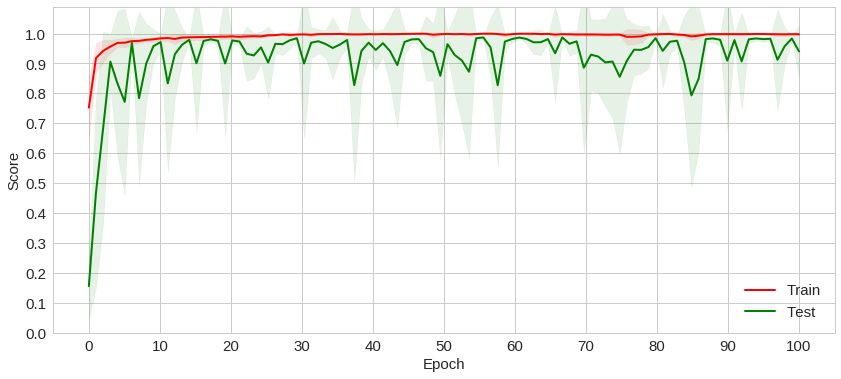

In [28]:
plot_mean_acc(hist)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-0.9,10.9))
    plt.show()

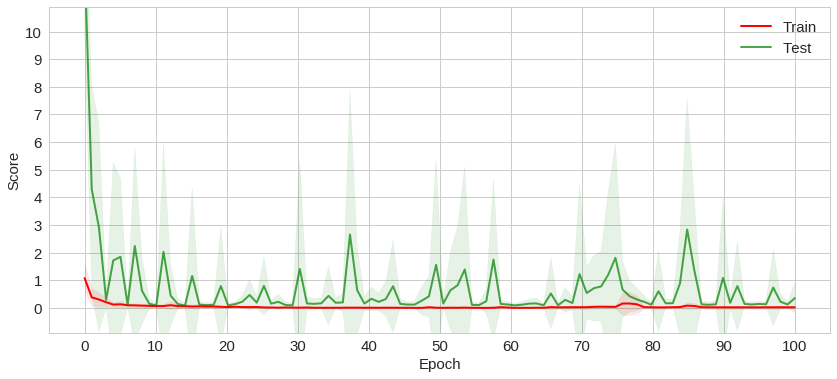

In [30]:
plot_mean_loss(hist)